In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os
from sklearn.metrics import mean_squared_error
import zipfile
from tensorflow.keras.models import load_model, Sequential
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# !pip install nbconvert
# !apt-get install texlive texlive-xetex texlive-latex-extra pandoc
# !jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/VN_Stock_Prediction_10.ipynb"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-fre

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# !jupyter nbconvert --to pdf --"/content/drive/MyDrive/Colab Notebooks/Current_VN_Code.pdf" "/content/drive/MyDrive/Colab Notebooks/VN_Stock_Prediction_10.ipynb"

[NbConvertApp] WARNING | pattern '--/content/drive/MyDrive/Colab Notebooks/Current_VN_Code.pdf' matched no files
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/VN_Stock_Prediction_10.ipynb to pdf
[NbConvertApp] Support files will be in VN_Stock_Prediction_10_files/
[NbConvertApp] Making directory ./VN_Stock_Prediction_10_files
[NbConvertApp] Writing 383245 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1500033 bytes to /content/drive/MyDrive/Colab Notebooks/VN_Stock_Prediction_10.pdf


In [ ]:
# First create a directory to extract to
import os
if not os.path.exists('/content/vn_data'):
    os.makedirs('/content/vn_data')

In [ ]:
# Unzip the data file to the created directory
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/data-vn-20230228.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/vn_data')

# **1-day forecast**

In [ ]:
def load_stock_data(ticker):
    index_patterns = ['-VNINDEX-', '-HNXIndex-', '-UpcomIndex-']
    for pattern in index_patterns:
        try:
            file_path = f"/content/vn_data/stock-historical-data/{ticker}{pattern}History.csv"
            df = pd.read_csv(file_path)
            return df
        except FileNotFoundError:
            continue
    raise FileNotFoundError(f"No data file found for ticker {ticker}")

In [ ]:
def filter_companies(min_data_points=120, exchanges=None, industries=None):
    ticker_overview = pd.read_csv("/content/vn_data/ticker-overview.csv")
    filtered_companies = []

    for _, company in ticker_overview.iterrows():
        ticker = company['ticker']
        try:
            df = load_stock_data(ticker)
            if len(df) < min_data_points:
                continue
            if exchanges and company['exchange'] not in exchanges:
                continue
            if industries and company['industryEn'] not in industries:
                continue
            filtered_companies.append(ticker)
        except FileNotFoundError:
            continue
    return filtered_companies

In [ ]:
# Example usage
exchanges = ['HOSE', 'HNX', 'UpcomIndex']
industries = ['Banks', 'Real Estate']
min_points = 120

filtered_tickers = filter_companies(
    min_data_points=min_points,
    exchanges=exchanges,
    industries=industries
)

print(f"Found {len(filtered_tickers)} companies matching criteria")

Found 98 companies matching criteria


In [ ]:
# Load data for filtered companies
for ticker in filtered_tickers[:5]:  # Example with first 5 companies
    try:
        df = load_stock_data(ticker)
        print(f"\nAnalyzing {ticker}")
        print(f"Number of data points: {len(df)}")
        print(f"Date range: {df['TradingDate'].min()} to {df['TradingDate'].max()}")
    except FileNotFoundError:
        print(f"Could not load data for {ticker}")


Analyzing AAV
Number of data points: 1171
Date range: 2018-06-25 to 2023-02-28

Analyzing ACB
Number of data points: 4052
Date range: 2006-11-21 to 2023-02-28

Analyzing AGG
Number of data points: 781
Date range: 2020-01-10 to 2023-02-28

Analyzing AMD
Number of data points: 2069
Date range: 2014-11-11 to 2023-02-28

Analyzing API
Number of data points: 3264
Date range: 2009-10-26 to 2023-02-28


In [ ]:
# Load data for HPG
ticker = 'HPG'  # Can be changed to any stock
df = load_stock_data(ticker)

print(f"Number of data points: {len(df)}")
print("\nFirst few rows of HPG data:")
print(df.head())
print("\nData info:")
df.info()

Number of data points: 3809

First few rows of HPG data:
   Unnamed: 0    Open    High     Low   Close   Volume TradingDate
0           0  2663.0  2704.0  2267.0  2642.0  1306330  2007-11-15
1           1  2517.0  2517.0  2517.0  2517.0   248510  2007-11-16
2           2  2392.0  2392.0  2392.0  2392.0   120480  2007-11-19
3           3  2288.0  2288.0  2288.0  2288.0    58710  2007-11-20
4           4  2184.0  2371.0  2184.0  2371.0   728080  2007-11-21

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3809 entries, 0 to 3808
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   3809 non-null   int64  
 1   Open         3809 non-null   float64
 2   High         3809 non-null   float64
 3   Low          3809 non-null   float64
 4   Close        3809 non-null   float64
 5   Volume       3809 non-null   int64  
 6   TradingDate  3809 non-null   object 
dtypes: float64(4), int64(2), object(1)
memor

In [ ]:
### Split the dataset into time windows to get data samples
X_data = []
y_data = []
label_index = 2  # Open price as label (index 2)
window_size = 30  # Time window for data feature (30 days)

# Get multiple features (Low, Open, High, Close, Volume)
for i in range(0, len(df) - window_size - 1):
    data_feature = []  # Number of day samples (window_size)
    data_label = []

    # Get a window_size time frame for data features
    for j in range(window_size):
        features = []  # Features per day sample
        features.append(df.iloc[i + j, 1])  # Add Low price feature
        features.append(df.iloc[i + j, 2])  # Add Open price feature
        features.append(df.iloc[i + j, 4])  # Add High price feature
        features.append(df.iloc[i + j, 5])  # Add Close price feature
        features.append(df.iloc[i + j, 3])  # Add Volume feature
        data_feature.append(features)

    # Next value is the label (price of the next day) to be predicted
    data_label.append(df.iloc[i + window_size, label_index])  # Add open price as label

    # Append new data sample to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 5))
    y_data.append(np.array(data_label))

In [ ]:
### Split the data into training, validation and test set
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape arrays to fit neural network input shape
X_train = X_train.reshape(X_train.shape[0], window_size, 5)
X_val = X_val.reshape(X_val.shape[0], window_size, 5)
X_test = X_test.reshape(X_test.shape[0], window_size, 5)

# Print shapes
print("\nShape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)


Shape of training set:  (2417, 30, 5)
Shape of validation set:  (605, 30, 5)
Shape of test set:  (756, 30, 5)


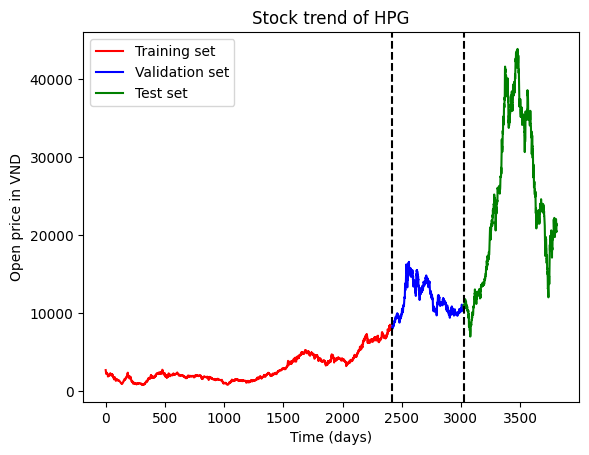

In [ ]:
# Visualize the training, validation and test set splits
df_plot = df['Open']
df_plot = df_plot.reset_index(drop=False)

size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of HPG")
plt.xlabel('Time (days)')
plt.ylabel('Open price in VND')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
### MinMax normalize the training data: x=(x-min(x))/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()

for i in range(0, len(X_train)):
    min_feature_label = -sys.maxsize - 1
    max_feature_label = sys.maxsize
    for j in range(0, len(X_train[0][0])):  # Number of features used
        # Calculate min and max to normalize features x
        min_feature = np.min(X_train[i][:,j])
        max_feature = np.max(X_train[i][:,j])
        X_train_norm[i][:,j] = (X_train[i][:,j] - min_feature) / (max_feature - min_feature)

    # Calculate min and max to normalize label y
    min_feature_label = np.min(X_train[i][:,label_index - 1])
    max_feature_label = np.max(X_train[i][:,label_index - 1])
    y_train_norm[i] = (y_train[i] - min_feature_label) / (max_feature_label - min_feature_label)

### MinMax normalize the validation data
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()

for i in range(0, len(X_val)):
    min_feature_label = -sys.maxsize - 1
    max_feature_label = sys.maxsize
    for j in range(0, len(X_val[0][0])):
        min_feature = np.min(X_val[i][:,j])
        max_feature = np.max(X_val[i][:,j])
        X_val_norm[i][:,j] = (X_val[i][:,j] - min_feature) / (max_feature - min_feature)

    min_feature_label = np.min(X_val[i][:,label_index - 1])
    max_feature_label = np.max(X_val[i][:,label_index - 1])
    y_val_norm[i] = (y_val[i] - min_feature_label) / (max_feature_label - min_feature_label)

In [ ]:
### Create and train the model
# Build model architecture
model = tf.keras.Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(window_size,5)))
model.add(LSTM(units=64))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

model_checkpoint = ModelCheckpoint(
    f'best_model_vietnam.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# Compile and train model
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm,
                   validation_data=(X_val_norm,y_val_norm),
                   epochs=30, batch_size=512,
                   callbacks=[early_stopping, model_checkpoint, reduce_lr])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 32)              │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,297 (141.79 KB)

 Trainable params: 36,297 (141.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - loss: 0.4597 - mse: 0.4597
Epoch 1: val_loss improved from inf to 0.15190, saving model to best_model_vietnam.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - loss: 0.3219 - mse: 0.3219 - val_loss: 0.1519 - val_mse: 0.1519 - learning_rate: 0.0100
Epoch 2/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1306 - mse: 0.1306
Epoch 2: val_loss improved from 0.15190 to 0.06369, saving model to best_model_vietnam.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1109 - mse: 0.1109 - val_loss: 0.0637 - val_mse: 0.0637 - learning_rate: 0.0100
Epoch 3/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0625 - mse: 0.0625
Epoch 3: val_loss improved from 0.06369 to 0.04386, saving model to best_model_vietnam.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0660 - mse: 0.0660 - val_loss: 0.0439 - val_mse: 0.0439 - learning_rate: 0.0100
Epoch 4/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0516 - mse: 0.0516
Epoch 4: val_loss improved fr

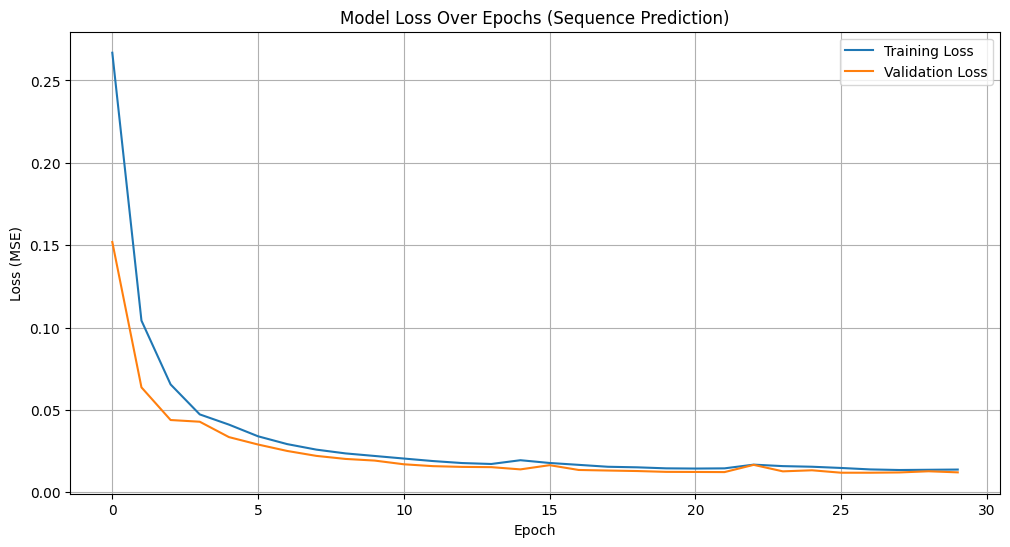

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs (Sequence Prediction)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### MinMax normalize the test data
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()

for i in range(0, len(X_test)):
    min_feature_label = -sys.maxsize - 1
    max_feature_label = sys.maxsize
    for j in range(0, len(X_test[0][0])):
        min_feature = np.min(X_test[i][:,j])
        max_feature = np.max(X_test[i][:,j])
        X_test_norm[i][:,j] = (X_test[i][:,j] - min_feature) / (max_feature - min_feature)

    min_feature_label = np.min(X_test[i][:,label_index - 1])
    max_feature_label = np.max(X_test[i][:,label_index - 1])
    y_test_norm[i] = (y_test[i] - min_feature_label) / (max_feature_label - min_feature_label)


In [ ]:
### Get prediction on test data and denormalize results
# Get prediction on test data
y_pred_norm = model.predict(X_test_norm)
test_mse = mean_squared_error(y_pred_norm, y_test_norm)
print("\nMSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

# Convert back to stock price (denormalize) for visualization
y_pred_denorm = y_pred_norm.copy()
for i in range(0, len(y_pred_denorm)):
    min_feature_label = np.min(X_test[i][:,label_index - 1])
    max_feature_label = np.max(X_test[i][:,label_index - 1])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature_label - min_feature_label) + min_feature_label


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

MSE on the test set:  0.011920373326975753


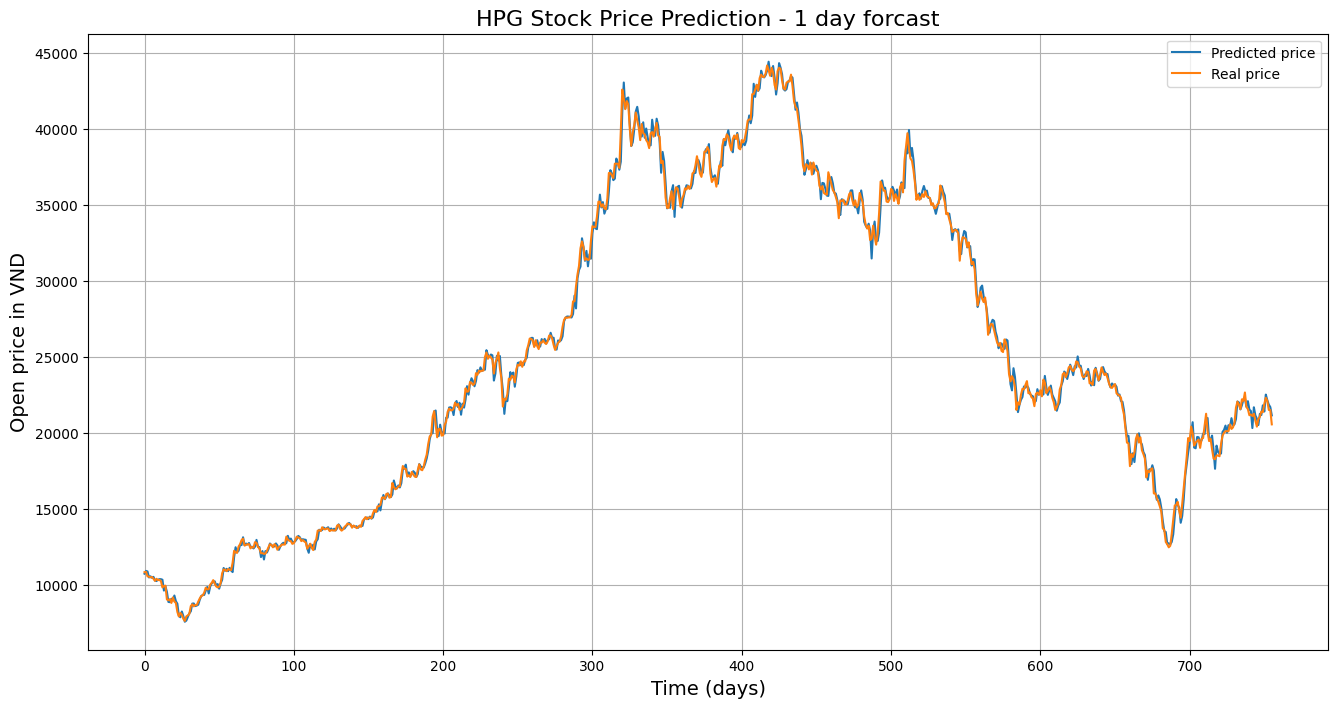

In [ ]:
# Visualize predicted vs real stock price
plt.figure(figsize=(16, 8))
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title(f'{ticker} Stock Price Prediction - 1 day forcast', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in VND', fontsize=14)
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Save the model with test MSE in filename
model_filename = f'model_test_mse_one_day{test_mse:.6f}.keras'
model.save(model_filename)
print(f'\nModel saved as: {model_filename}')


Model saved as: model_test_mse_one_day0.011977.keras


# **K-day Prediction**

In [ ]:
# Load HPG stock data with distinct function name
def load_stock_data_kday(stock_ticker):
    # Try each possible index pattern
    index_patterns = ['-VNINDEX-', '-HNXIndex-', '-UpcomIndex-']

    for pattern in index_patterns:
        try:
            file_path = f"/content/vn_data/stock-historical-data/{ticker}{pattern}History.csv"
            df = pd.read_csv(file_path)
            print(f"Loaded {ticker} data from {file_path}")
            return df
        except FileNotFoundError:
            continue

    # If no file is found with any pattern
    raise FileNotFoundError(f"No data file found for ticker {ticker} with any known index pattern")

In [ ]:
# Load data for HPG
# Define stock ticker as a variable at the start
stock_ticker = 'HPG'  # Can be changed to any stock

# Load data using the variable
df_k = load_stock_data_kday(stock_ticker)

Loaded HPG data from /content/vn_data/stock-historical-data/HPG-VNINDEX-History.csv


In [ ]:
### Split dataset into time windows with k-day prediction
X_data_k = []
y_data_k = []
label_index_k = 2  # Open price as label
window_size_k = 30  # Time window
k = 7  # Predict k days ahead

# Get multiple features for k-day prediction
for i in range(0, len(df_k) - window_size_k - k):
    data_feature_k = []
    data_label_k = []

    # Get window_size time frame for data features
    for j in range(window_size_k):
        features_k = []
        features_k.append(df_k.iloc[i + j, 1])  # Low
        features_k.append(df_k.iloc[i + j, 2])  # Open
        features_k.append(df_k.iloc[i + j, 4])  # High
        features_k.append(df_k.iloc[i + j, 5])  # Close
        features_k.append(df_k.iloc[i + j, 3])  # Volume
        data_feature_k.append(features_k)

    # k-th day ahead is the label to be predicted
    data_label_k.append(df_k.iloc[i + window_size_k + k - 1, label_index_k])

    X_data_k.append(np.array(data_feature_k).reshape(window_size_k, 5))
    y_data_k.append(np.array(data_label_k))

In [ ]:
### Split into training, validation and test sets
from sklearn.model_selection import train_test_split

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_data_k, y_data_k, test_size=0.2, shuffle=False)
X_train_k, X_val_k, y_train_k, y_val_k = train_test_split(X_train_k, y_train_k, test_size=0.2, shuffle=False)

# Convert to Numpy arrays
X_train_k = np.array(X_train_k)
X_val_k = np.array(X_val_k)
X_test_k = np.array(X_test_k)
y_train_k = np.array(y_train_k)
y_val_k = np.array(y_val_k)
y_test_k = np.array(y_test_k)

# Reshape arrays
X_train_k = X_train_k.reshape(X_train_k.shape[0], window_size_k, 5)
X_val_k = X_val_k.reshape(X_val_k.shape[0], window_size_k, 5)
X_test_k = X_test_k.reshape(X_test_k.shape[0], window_size_k, 5)

In [ ]:
### MinMax normalize training data
X_train_norm_k = X_train_k.copy()
y_train_norm_k = y_train_k.copy()

for i in range(0, len(X_train_k)):
    min_feature_label_k = -sys.maxsize - 1
    max_feature_label_k = sys.maxsize
    for j in range(0, len(X_train_k[0][0])):
        min_feature_k = np.min(X_train_k[i][:,j])
        max_feature_k = np.max(X_train_k[i][:,j])
        X_train_norm_k[i][:,j] = (X_train_k[i][:,j] - min_feature_k) / (max_feature_k - min_feature_k)

    min_feature_label_k = np.min(X_train_k[i][:,label_index_k - 1])
    max_feature_label_k = np.max(X_train_k[i][:,label_index_k - 1])
    y_train_norm_k[i] = (y_train_k[i] - min_feature_label_k) / (max_feature_label_k - min_feature_label_k)

### MinMax normalize validation data
X_val_norm_k = X_val_k.copy()
y_val_norm_k = y_val_k.copy()

for i in range(0, len(X_val_k)):
    min_feature_label_k = -sys.maxsize - 1
    max_feature_label_k = sys.maxsize
    for j in range(0, len(X_val_k[0][0])):
        min_feature_k = np.min(X_val_k[i][:,j])
        max_feature_k = np.max(X_val_k[i][:,j])
        X_val_norm_k[i][:,j] = (X_val_k[i][:,j] - min_feature_k) / (max_feature_k - min_feature_k)

    min_feature_label_k = np.min(X_val_k[i][:,label_index_k - 1])
    max_feature_label_k = np.max(X_val_k[i][:,label_index_k - 1])
    y_val_norm_k[i] = (y_val_k[i] - min_feature_label_k) / (max_feature_label_k - min_feature_label_k)


In [ ]:
### Create and train k-day model
model_k = tf.keras.Sequential()
model_k.add(LSTM(units=32, return_sequences=True, input_shape=(window_size_k,5)))
model_k.add(LSTM(units=64))
model_k.add(Dense(100, activation='relu'))
model_k.add(Dense(1))

model_checkpoint_k = ModelCheckpoint(
    f'best_model_vietnam_kday.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_k = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_k = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

model_k.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mse',
              metrics=['mse'])

history_k = model_k.fit(X_train_norm_k, y_train_norm_k,
                     validation_data=(X_val_norm_k,y_val_norm_k),
                     epochs=30, batch_size=512,
                     callbacks=[early_stopping_k, model_checkpoint_k, reduce_lr_k])


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.7100 - mse: 0.7100
Epoch 1: val_loss improved from inf to 0.33680, saving model to best_model_vietnam_kday.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.5816 - mse: 0.5816 - val_loss: 0.3368 - val_mse: 0.3368 - learning_rate: 0.0100
Epoch 2/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3903 - mse: 0.3903
Epoch 2: val_loss improved from 0.33680 to 0.21980, saving model to best_model_vietnam_kday.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3368 - mse: 0.3368 - val_loss: 0.2198 - val_mse: 0.2198 - learning_rate: 0.0100
Epoch 3/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2513 - mse: 0.2513
Epoch 3: val_loss improved from 0.21980 to 0.21551, saving model to best_model_vietnam_kday.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2664 - mse: 0.2664 - val_loss: 0.2155 - val_mse: 0.2155 - learning_rate: 0.0100
Epoch 4/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2880 - mse: 0.2880
Epoch 4: val_loss improved 

In [ ]:
### MinMax normalize test data
X_test_norm_k = X_test_k.copy()
y_test_norm_k = y_test_k.copy()

for i in range(0, len(X_test_k)):
    min_feature_label_k = -sys.maxsize - 1
    max_feature_label_k = sys.maxsize
    for j in range(0, len(X_test_k[0][0])):
        min_feature_k = np.min(X_test_k[i][:,j])
        max_feature_k = np.max(X_test_k[i][:,j])
        X_test_norm_k[i][:,j] = (X_test_k[i][:,j] - min_feature_k) / (max_feature_k - min_feature_k)

    min_feature_label_k = np.min(X_test_k[i][:,label_index_k - 1])
    max_feature_label_k = np.max(X_test_k[i][:,label_index_k - 1])
    y_test_norm_k[i] = (y_test_k[i] - min_feature_label_k) / (max_feature_label_k - min_feature_label_k)

In [ ]:
### Get prediction and denormalize results
y_pred_norm_k = model_k.predict(X_test_norm_k)
print(f"\nMSE on the test set for {k}-day prediction: ",
      mean_squared_error(y_pred_norm_k, y_test_norm_k))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

MSE on the test set for 7-day prediction:  0.17872524221446837


In [ ]:
# Denormalize predictions
y_pred_denorm_k = y_pred_norm_k.copy()
for i in range(0, len(y_pred_denorm_k)):
    min_feature_label_k = np.min(X_test_k[i][:,label_index_k - 1])
    max_feature_label_k = np.max(X_test_k[i][:,label_index_k - 1])
    y_pred_denorm_k[i] = y_pred_norm_k[i] * (max_feature_label_k - min_feature_label_k) + min_feature_label_k

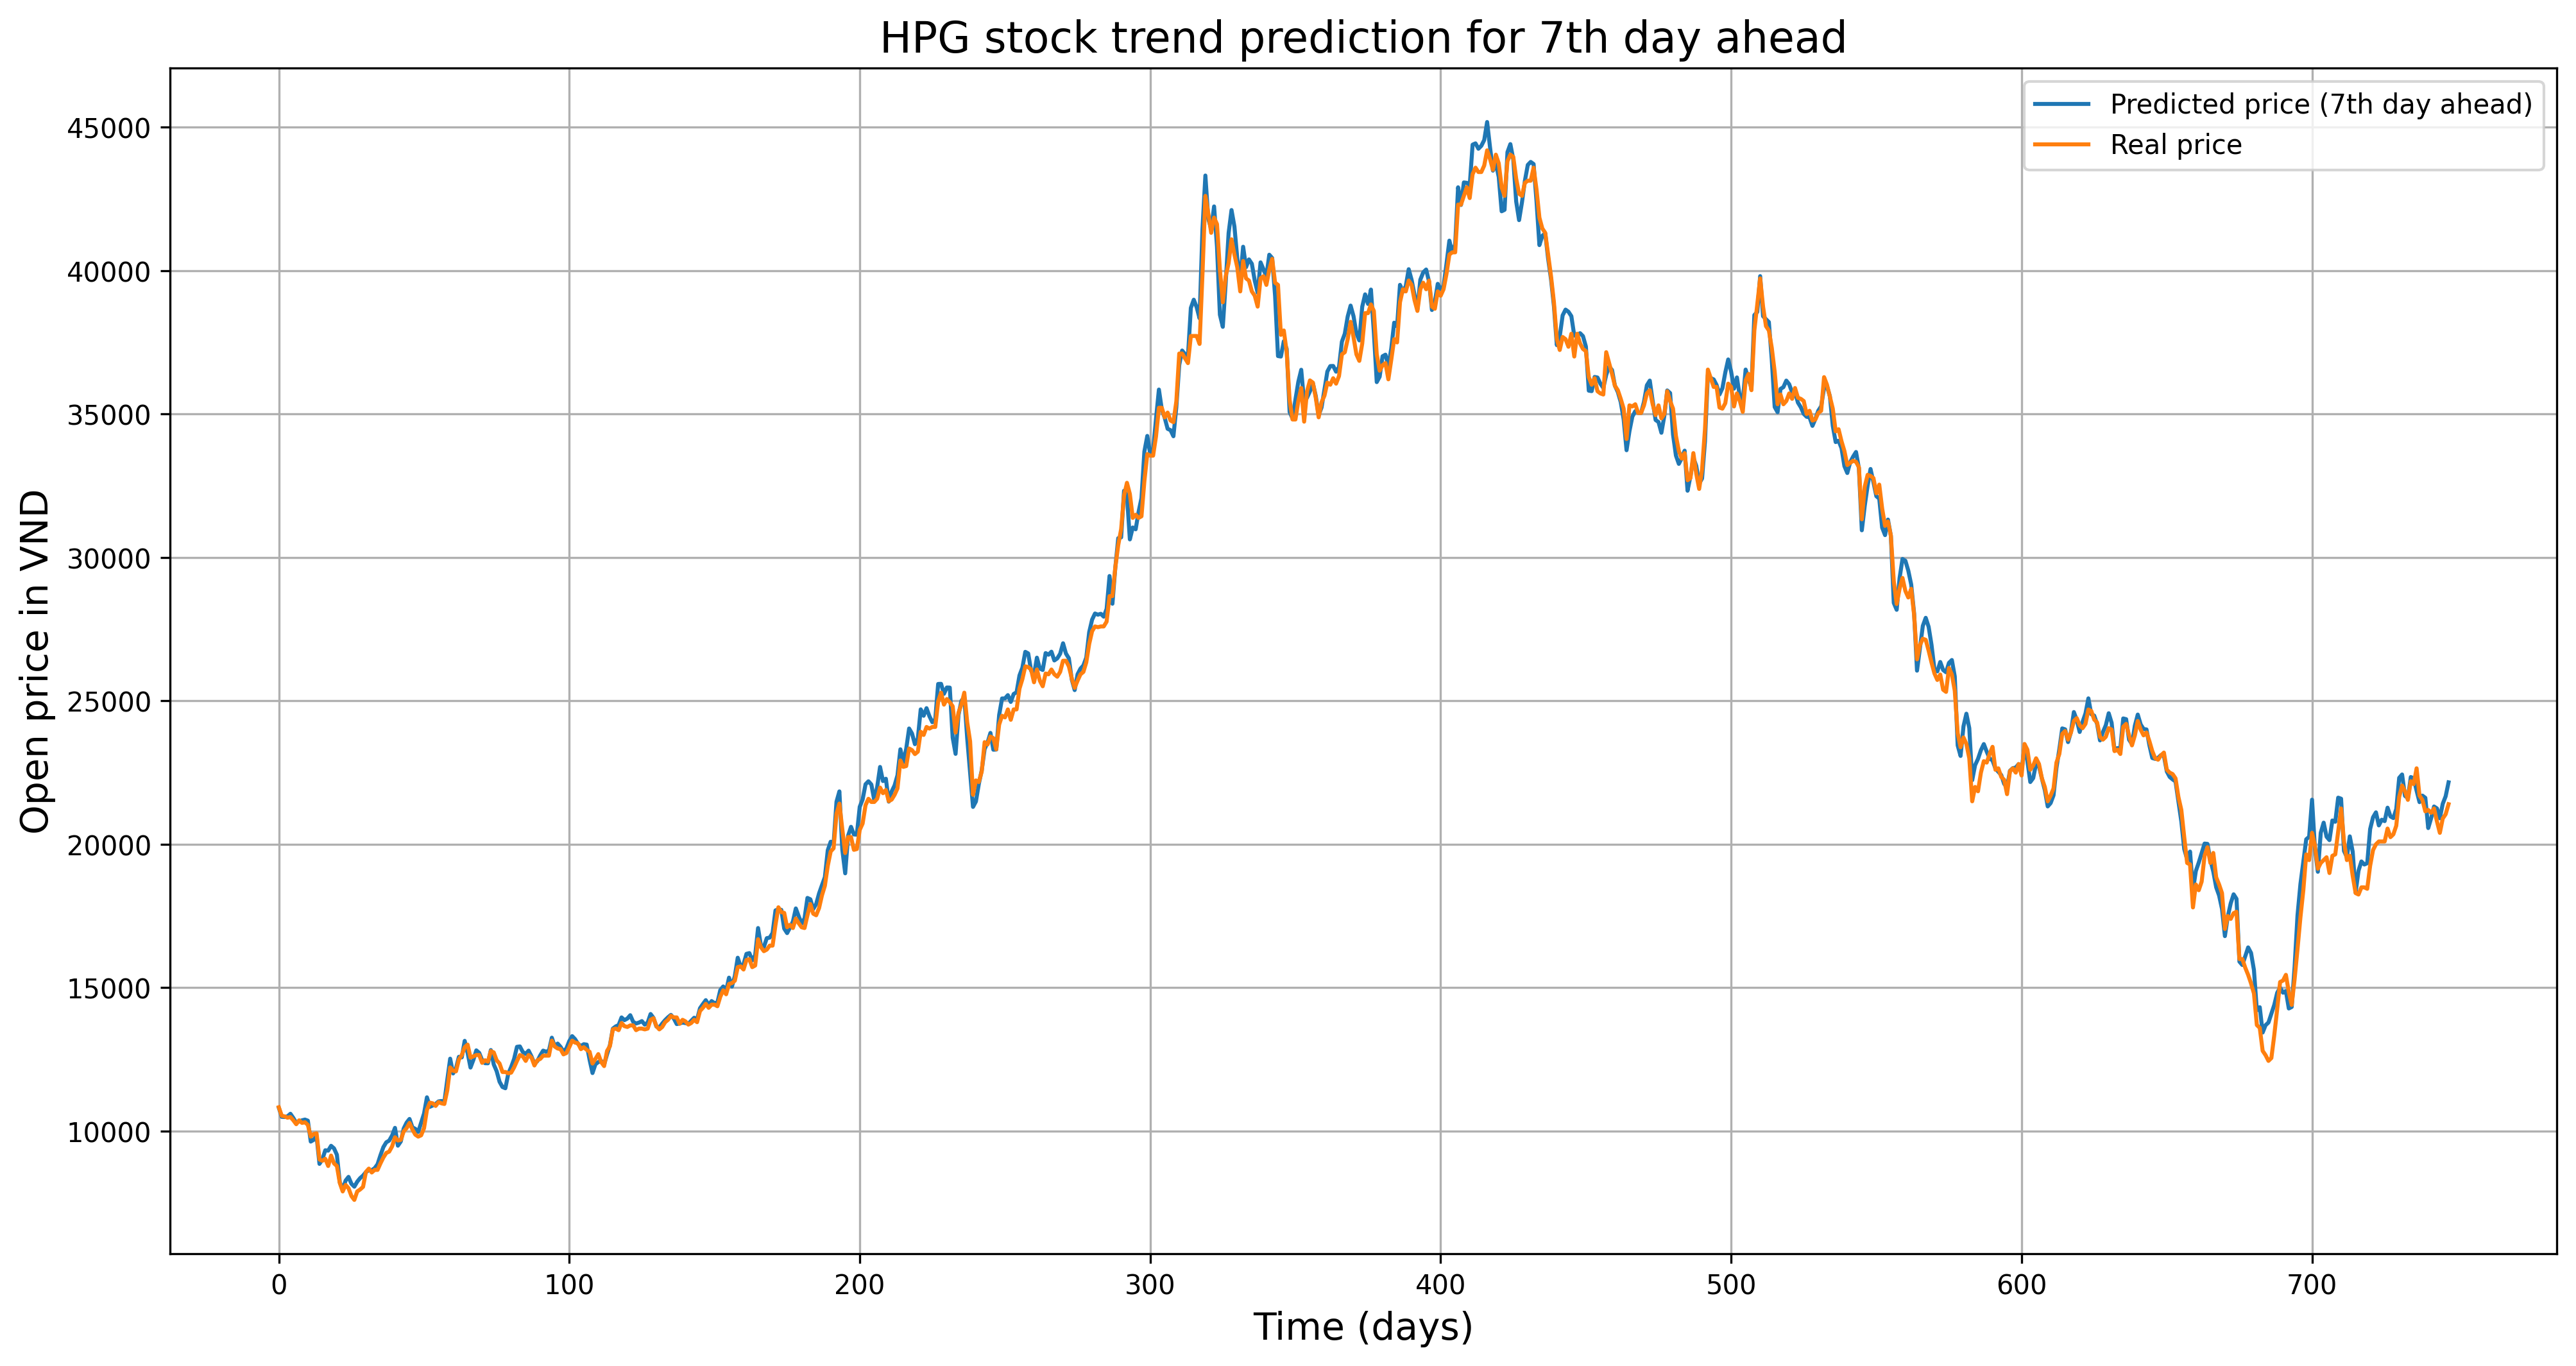

In [ ]:
# Visualize predicted stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)

# Create time indices for proper alignment
time_index = np.arange(len(y_test_k) - k)  # Adjust for k-day ahead prediction

# Plot predicted values shifted forward by k days
plt.plot(time_index, y_pred_denorm_k[k:], label=f'Predicted price ({k}th day ahead)')
plt.plot(time_index, y_test_k[:-k], label='Real price')
plt.title(f'{stock_ticker} stock trend prediction for {k}th day ahead', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in VND', fontsize=14)
plt.grid()  # Add grid
plt.legend()  # Add legend
plt.show()

# **K-consecutive days**

In [ ]:
# Load stock data with distinct function name
def load_stock_data_consecutive(stock_ticker):
    # Try each possible index pattern
    index_patterns = ['-VNINDEX-', '-HNXIndex-', '-UpcomIndex-']

    for pattern in index_patterns:
        try:
            file_path = f"/content/vn_data/stock-historical-data/{ticker}{pattern}History.csv"
            df = pd.read_csv(file_path)
            print(f"Loaded {ticker} data from {file_path}")
            return df
        except FileNotFoundError:
            continue

    # If no file is found with any pattern
    raise FileNotFoundError(f"No data file found for ticker {ticker} with any known index pattern")

In [ ]:
# Define stock ticker
stock_ticker = 'HPG'  # Can be changed to any stock
df_c = load_stock_data_consecutive(stock_ticker)

Loaded HPG data from /content/vn_data/stock-historical-data/HPG-VNINDEX-History.csv


In [ ]:
### Split dataset for consecutive day prediction
X_data_c = []
y_data_c = []
label_index_c = 2  # Open price as label
window_size_c = 30  # Time window
k_days = 7  # Predict next k consecutive days

# Get features and k consecutive days labels
for i in range(0, len(df_c) - window_size_c - k_days):
    data_feature_c = []
    data_label_c = []

    # Get window_size time frame for features
    for j in range(window_size_c):
        features_c = []
        features_c.append(df_c.iloc[i + j, 1])  # Low
        features_c.append(df_c.iloc[i + j, 2])  # Open
        features_c.append(df_c.iloc[i + j, 4])  # High
        features_c.append(df_c.iloc[i + j, 5])  # Close
        features_c.append(df_c.iloc[i + j, 3])  # Volume
        data_feature_c.append(features_c)

    # Get next k consecutive days as labels
    for j in range(k_days):
        data_label_c.append(df_c.iloc[i + window_size_c + j, label_index_c])

    X_data_c.append(np.array(data_feature_c).reshape(window_size_c, 5))
    y_data_c.append(np.array(data_label_c))

In [ ]:
### Split into training, validation and test sets
from sklearn.model_selection import train_test_split

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_data_c, y_data_c, test_size=0.2, shuffle=False)
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_train_c, y_train_c, test_size=0.2, shuffle=False)

# Convert to Numpy arrays
X_train_c = np.array(X_train_c)
X_val_c = np.array(X_val_c)
X_test_c = np.array(X_test_c)
y_train_c = np.array(y_train_c)
y_val_c = np.array(y_val_c)
y_test_c = np.array(y_test_c)

# Reshape arrays
X_train_c = X_train_c.reshape(X_train_c.shape[0], window_size_c, 5)
X_val_c = X_val_c.reshape(X_val_c.shape[0], window_size_c, 5)
X_test_c = X_test_c.reshape(X_test_c.shape[0], window_size_c, 5)

In [ ]:
### MinMax normalize training data
X_train_norm_c = X_train_c.copy()
y_train_norm_c = y_train_c.copy()

for i in range(0, len(X_train_c)):
    min_feature_label_c = -sys.maxsize - 1
    max_feature_label_c = sys.maxsize
    for j in range(0, len(X_train_c[0][0])):
        min_feature_c = np.min(X_train_c[i][:,j])
        max_feature_c = np.max(X_train_c[i][:,j])
        X_train_norm_c[i][:,j] = (X_train_c[i][:,j] - min_feature_c) / (max_feature_c - min_feature_c)

    min_feature_label_c = np.min(X_train_c[i][:,label_index_c - 1])
    max_feature_label_c = np.max(X_train_c[i][:,label_index_c - 1])
    y_train_norm_c[i] = (y_train_c[i] - min_feature_label_c) / (max_feature_label_c - min_feature_label_c)

### MinMax normalize validation data
X_val_norm_c = X_val_c.copy()
y_val_norm_c = y_val_c.copy()

for i in range(0, len(X_val_c)):
    min_feature_label_c = -sys.maxsize - 1
    max_feature_label_c = sys.maxsize
    for j in range(0, len(X_val_c[0][0])):
        min_feature_c = np.min(X_val_c[i][:,j])
        max_feature_c = np.max(X_val_c[i][:,j])
        X_val_norm_c[i][:,j] = (X_val_c[i][:,j] - min_feature_c) / (max_feature_c - min_feature_c)

    min_feature_label_c = np.min(X_val_c[i][:,label_index_c - 1])
    max_feature_label_c = np.max(X_val_c[i][:,label_index_c - 1])
    y_val_norm_c[i] = (y_val_c[i] - min_feature_label_c) / (max_feature_label_c - min_feature_label_c)

In [ ]:
### Create and train consecutive days model
model_c = tf.keras.Sequential()
model_c.add(LSTM(units=32, return_sequences=True, input_shape=(window_size_c,5)))
model_c.add(LSTM(units=64))
model_c.add(Dense(100, activation='relu'))
model_c.add(Dense(k_days))  # Output layer has k_days units for consecutive predictions

model_checkpoint_c = ModelCheckpoint(
    f'best_model_vietnam_consecutive.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_c = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_c = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

model_c.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mse',
              metrics=['mse'])

history_c = model_c.fit(X_train_norm_c, y_train_norm_c,
                     validation_data=(X_val_norm_c,y_val_norm_c),
                     epochs=30, batch_size=512,
                     callbacks=[early_stopping_c, model_checkpoint_c, reduce_lr_c])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.5851 - mse: 0.5851
Epoch 1: val_loss improved from inf to 0.30516, saving model to best_model_vietnam_consecutive.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.5092 - mse: 0.5092 - val_loss: 0.3052 - val_mse: 0.3052 - learning_rate: 0.0100
Epoch 2/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3462 - mse: 0.3462
Epoch 2: val_loss improved from 0.30516 to 0.22660, saving model to best_model_vietnam_consecutive.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3136 - mse: 0.3136 - val_loss: 0.2266 - val_mse: 0.2266 - learning_rate: 0.0100
Epoch 3/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2750 - mse: 0.2750
Epoch 3: val_loss improved from 0.22660 to 0.20018, saving model to best_model_vietnam_consecutive.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2507 - mse: 0.2507 - val_loss: 0.2002 - val_mse: 0.2002 - learning_rate: 0.0100
Epoch 4/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2305 - mse: 0.2305
Epoch 

In [ ]:
### MinMax normalize test data
X_test_norm_c = X_test_c.copy()
y_test_norm_c = y_test_c.copy()

for i in range(0, len(X_test_c)):
    min_feature_label_c = -sys.maxsize - 1
    max_feature_label_c = sys.maxsize
    for j in range(0, len(X_test_c[0][0])):
        min_feature_c = np.min(X_test_c[i][:,j])
        max_feature_c = np.max(X_test_c[i][:,j])
        X_test_norm_c[i][:,j] = (X_test_c[i][:,j] - min_feature_c) / (max_feature_c - min_feature_c)

    min_feature_label_c = np.min(X_test_c[i][:,label_index_c - 1])
    max_feature_label_c = np.max(X_test_c[i][:,label_index_c - 1])
    y_test_norm_c[i] = (y_test_c[i] - min_feature_label_c) / (max_feature_label_c - min_feature_label_c)

In [ ]:
### Get predictions and denormalize results
y_pred_norm_c = model_c.predict(X_test_norm_c)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
for day in range(k_days):
    mse = mean_squared_error(y_test_norm_c[:, day], y_pred_norm_c[:, day])
    print(f"MSE for day {day+1}: {mse}")

MSE for day 1: 0.01395547785770287
MSE for day 2: 0.03676367022525362
MSE for day 3: 0.059642107534583225
MSE for day 4: 0.08340998396653673
MSE for day 5: 0.11239356802757232
MSE for day 6: 0.1414772519607118
MSE for day 7: 0.17216906675243024


In [ ]:
# Denormalize predictions
y_pred_denorm_c = y_pred_norm_c.copy()
for i in range(0, len(y_pred_denorm_c)):
    min_feature_label_c = np.min(X_test_c[i][:,label_index_c - 1])
    max_feature_label_c = np.max(X_test_c[i][:,label_index_c - 1])
    y_pred_denorm_c[i] = y_pred_norm_c[i] * (max_feature_label_c - min_feature_label_c) + min_feature_label_c

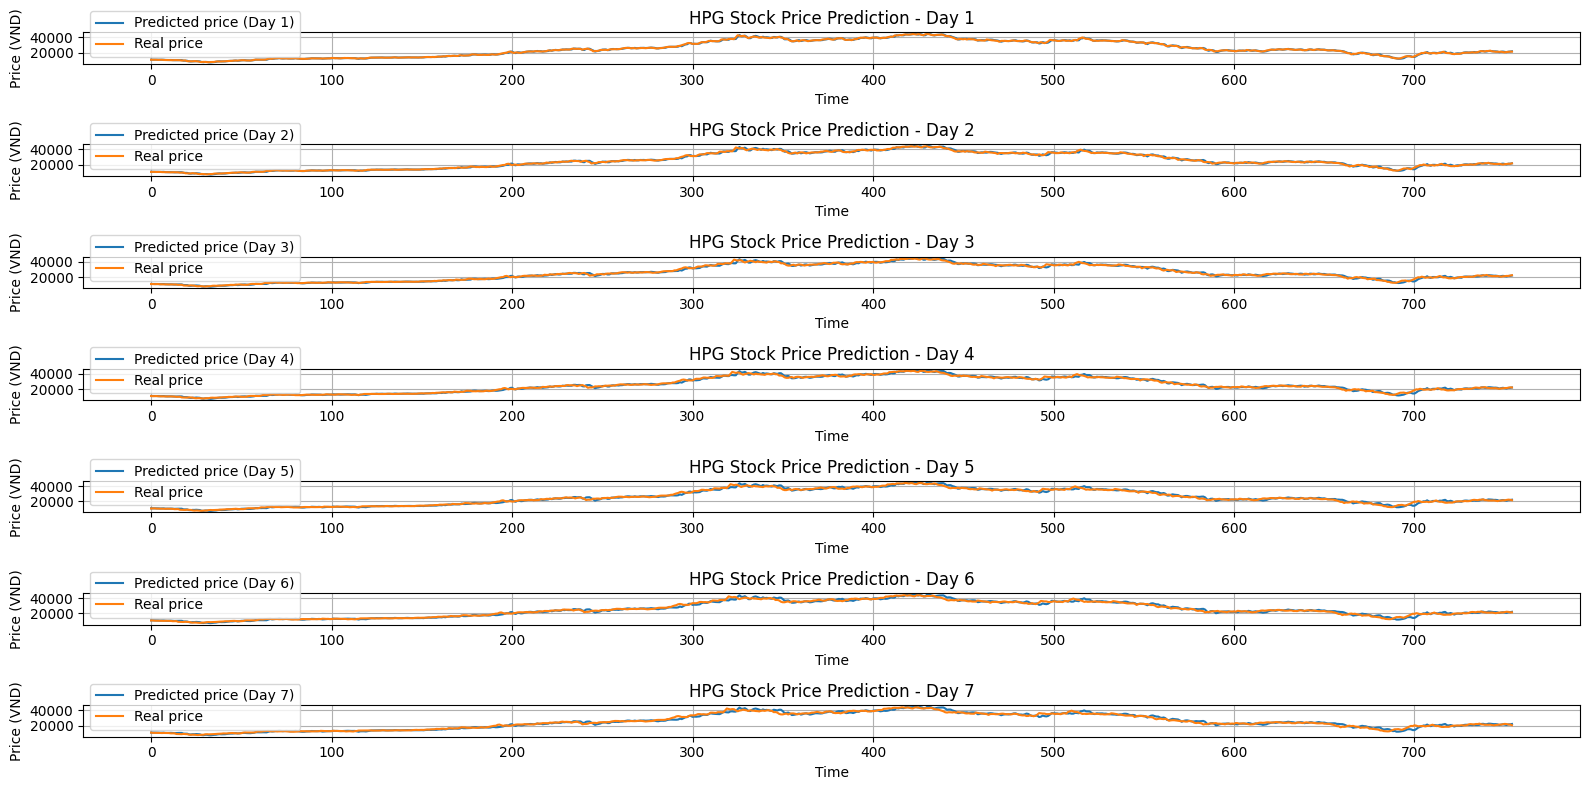

In [ ]:
# Visualize results for each day
plt.figure(figsize=(16, 8))
for day in range(k_days):
    plt.subplot(k_days, 1, day+1)
    plt.plot(y_pred_denorm_c[:, day], label=f'Predicted price (Day {day+1})')
    plt.plot(y_test_c[:, day], label='Real price')
    plt.title(f'{stock_ticker} Stock Price Prediction - Day {day+1}', fontsize=12)
    plt.xlabel('Time', fontsize=10)
    plt.ylabel('Price (VND)', fontsize=10)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

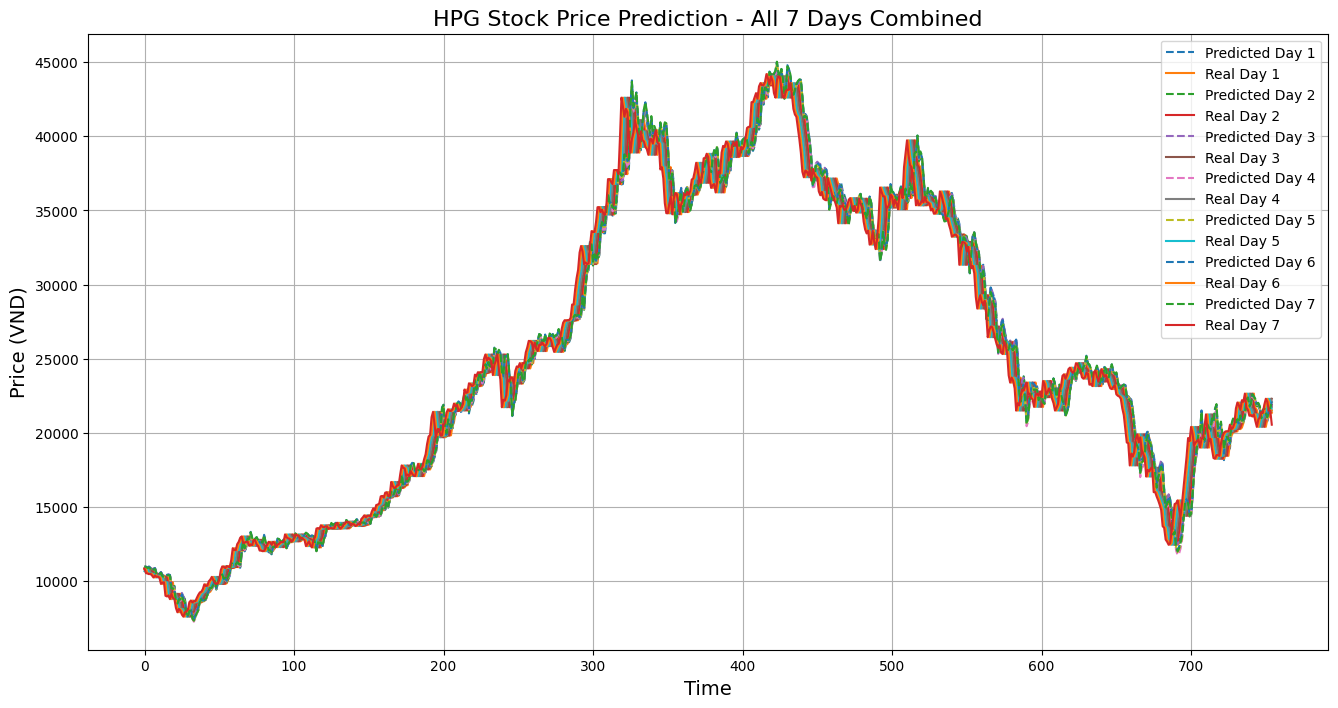

In [ ]:
# Plot combined predictions
plt.figure(figsize=(16, 8))
for day in range(k_days):
    plt.plot(y_pred_denorm_c[:, day], '--', label=f'Predicted Day {day+1}')
    plt.plot(y_test_c[:, day], '-', label=f'Real Day {day+1}')
plt.title(f'{stock_ticker} Stock Price Prediction - All {k_days} Days Combined', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price (VND)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# **Buying signal Indentifications**

# **Testing the buying algorithm with available model**

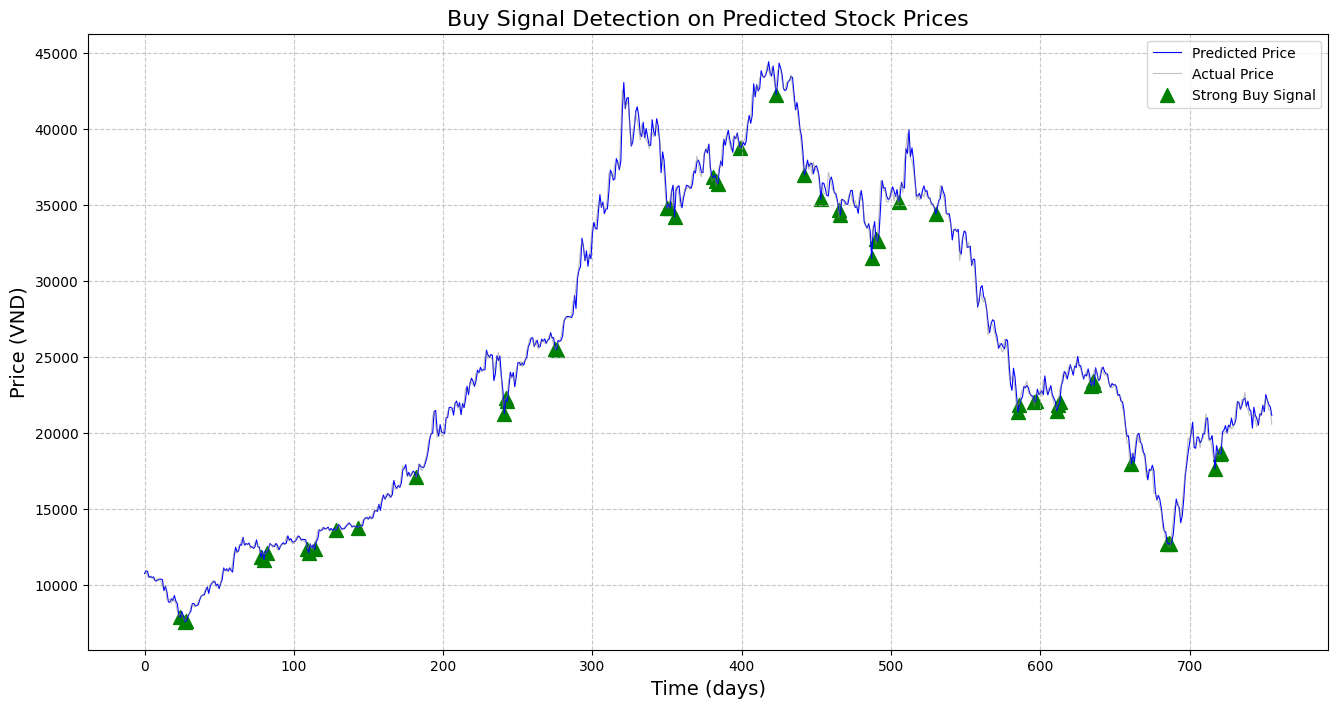


Number of buy signals detected: 51
Average predicted price at buy signals: 23370.066
Average actual price at buy signals: 23637.274509803923


In [ ]:
# First get predictions from model (using previous predicted values)
y_pred_denorm = y_pred_denorm  # The denormalized predictions from first model
y_test = y_test  # The actual test data for comparison

# Create a DataFrame with both predicted and actual prices
df_analysis = pd.DataFrame({
    'Open': y_pred_denorm.flatten(),  # Using predicted prices
    'Real_Open': y_test.flatten()  # Actual prices for reference
})

# Define the time window size
window_size = 20  # Ensure an odd number to have the "present point" in the middle
k_days_future = 7  # Forecast k days into the future

# Add a column for Buy Signal Probability
df_analysis['Buy_Prob'] = 0.0  # Initialize with 0

# Add a smoothed predicted price column (7-day moving average)
df_analysis['Smoothed_Open'] = df_analysis['Open'].rolling(window=7).mean()

# Define a global price threshold for "low prices" based on predicted prices
global_threshold = np.percentile(df_analysis['Open'], 10)  # Bottom 10% of predicted prices

# Iterate through the dataset, leaving margins for the window
for i in range(window_size // 2, len(df_analysis) - window_size // 2 - k_days_future):
    # Define the time window indices
    start_idx = i - window_size // 2
    end_idx = i + window_size // 2 + 1
    time_window = df_analysis.iloc[start_idx:end_idx]['Open']

    # Get the "present point" predicted price
    present_price = df_analysis.iloc[i]['Open']

    # Calculate the threshold for this window
    threshold = np.percentile(time_window, 10)

    # Check if the present price is in the bottom 10% and below the moving average
    if (present_price <= threshold) and (present_price < df_analysis.iloc[i]['Smoothed_Open']):
        df_analysis.at[i, 'Buy_Prob'] = 1.0  # Strong buy signal
    else:
        # Probability score relative to price position in the range
        df_analysis.at[i, 'Buy_Prob'] = max(0, 1 - (present_price - time_window.min()) /
                                          (time_window.max() - time_window.min()))

# Visualization
plt.figure(figsize=(16, 8))

# Plot predicted prices
plt.plot(df_analysis['Open'], label='Predicted Price', color='blue', linewidth=0.8)

# Plot actual prices
plt.plot(df_analysis['Real_Open'], label='Actual Price', color='gray', alpha=0.5, linewidth=0.8)

# Add markers for Buy Signals
buy_signals = df_analysis[df_analysis['Buy_Prob'] == 1.0]
plt.scatter(
    buy_signals.index,
    buy_signals['Open'],
    color='green',
    label='Strong Buy Signal',
    marker='^',
    s=100
)

# Enhance the visualization
plt.title(f'Buy Signal Detection on Predicted Stock Prices', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Price (VND)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Print some statistics
print("\nNumber of buy signals detected:", len(buy_signals))
if len(buy_signals) > 0:
    print("Average predicted price at buy signals:", buy_signals['Open'].mean())
    print("Average actual price at buy signals:", buy_signals['Real_Open'].mean())

# **Buying Signal - Specific Trading Date**

In [ ]:
# Load stock data with distinct function name
def load_stock_data_buy(stock_ticker):
    # Try each possible index pattern
    index_patterns = ['-VNINDEX-', '-HNXIndex-', '-UpcomIndex-']

    for pattern in index_patterns:
        try:
            file_path = f"/content/vn_data/stock-historical-data/{ticker}{pattern}History.csv"
            df = pd.read_csv(file_path)
            print(f"Loaded {ticker} data from {file_path}")
            return df
        except FileNotFoundError:
            continue

    # If no file is found with any pattern
    raise FileNotFoundError(f"No data file found for ticker {ticker} with any known index pattern")

# Define stock ticker
stock_ticker = 'HPG'  # Can be changed to any stock
df_buy = load_stock_data_buy(stock_ticker)

### Split dataset for buy signal prediction
X_data_buy = []
y_data_buy = []
label_index_buy = 2  # Open price as label
window_size_buy = 30  # Time window
k_days = 7  # Predict next k consecutive days

# Get features and k consecutive days labels
for i in range(0, len(df_buy) - window_size_buy - k_days):
    data_feature_buy = []
    data_label_buy = []

    # Get window_size time frame for features
    for j in range(window_size_buy):
        features_buy = []
        features_buy.append(df_buy.iloc[i + j, 1])  # Low
        features_buy.append(df_buy.iloc[i + j, 2])  # Open
        features_buy.append(df_buy.iloc[i + j, 4])  # High
        features_buy.append(df_buy.iloc[i + j, 5])  # Close
        features_buy.append(df_buy.iloc[i + j, 3])  # Volume
        data_feature_buy.append(features_buy)

    # Get next k consecutive days as labels
    for j in range(k_days):
        data_label_buy.append(df_buy.iloc[i + window_size_buy + j, label_index_buy])

    X_data_buy.append(np.array(data_feature_buy).reshape(window_size_buy, 5))
    y_data_buy.append(np.array(data_label_buy))

### Split into training, validation and test sets
from sklearn.model_selection import train_test_split

X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X_data_buy, y_data_buy, test_size=0.2, shuffle=False)
X_train_buy, X_val_buy, y_train_buy, y_val_buy = train_test_split(X_train_buy, y_train_buy, test_size=0.2, shuffle=False)

# Convert to Numpy arrays
X_train_buy = np.array(X_train_buy)
X_val_buy = np.array(X_val_buy)
X_test_buy = np.array(X_test_buy)
y_train_buy = np.array(y_train_buy)
y_val_buy = np.array(y_val_buy)
y_test_buy = np.array(y_test_buy)

# Reshape arrays
X_train_buy = X_train_buy.reshape(X_train_buy.shape[0], window_size_buy, 5)
X_val_buy = X_val_buy.reshape(X_val_buy.shape[0], window_size_buy, 5)
X_test_buy = X_test_buy.reshape(X_test_buy.shape[0], window_size_buy, 5)

### MinMax normalize training data
X_train_norm_buy = X_train_buy.copy()
y_train_norm_buy = y_train_buy.copy()

for i in range(0, len(X_train_buy)):
    min_feature_label_buy = -sys.maxsize - 1
    max_feature_label_buy = sys.maxsize
    for j in range(0, len(X_train_buy[0][0])):
        min_feature_buy = np.min(X_train_buy[i][:,j])
        max_feature_buy = np.max(X_train_buy[i][:,j])
        X_train_norm_buy[i][:,j] = (X_train_buy[i][:,j] - min_feature_buy) / (max_feature_buy - min_feature_buy)

    min_feature_label_buy = np.min(X_train_buy[i][:,label_index_buy - 1])
    max_feature_label_buy = np.max(X_train_buy[i][:,label_index_buy - 1])
    y_train_norm_buy[i] = (y_train_buy[i] - min_feature_label_buy) / (max_feature_label_buy - min_feature_label_buy)

### MinMax normalize validation data
X_val_norm_buy = X_val_buy.copy()
y_val_norm_buy = y_val_buy.copy()

for i in range(0, len(X_val_buy)):
    min_feature_label_buy = -sys.maxsize - 1
    max_feature_label_buy = sys.maxsize
    for j in range(0, len(X_val_buy[0][0])):
        min_feature_buy = np.min(X_val_buy[i][:,j])
        max_feature_buy = np.max(X_val_buy[i][:,j])
        X_val_norm_buy[i][:,j] = (X_val_buy[i][:,j] - min_feature_buy) / (max_feature_buy - min_feature_buy)

    min_feature_label_buy = np.min(X_val_buy[i][:,label_index_buy - 1])
    max_feature_label_buy = np.max(X_val_buy[i][:,label_index_buy - 1])
    y_val_norm_buy[i] = (y_val_buy[i] - min_feature_label_buy) / (max_feature_label_buy - min_feature_label_buy)

### Create and train buy signal model
model_buy = tf.keras.Sequential()
model_buy.add(LSTM(units=32, return_sequences=True, input_shape=(window_size_buy,5)))
model_buy.add(LSTM(units=64))
model_buy.add(Dense(100, activation='relu'))
model_buy.add(Dense(k_days))  # Output layer has k_days units for consecutive predictions

model_checkpoint_buy = ModelCheckpoint(
    f'best_model_vietnam_buy.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_buy = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_buy = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

model_buy.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss='mse',
                  metrics=['mse'])

history_buy = model_buy.fit(X_train_norm_buy, y_train_norm_buy,
                            validation_data=(X_val_norm_buy, y_val_norm_buy),
                            epochs=30, batch_size=512,
                            callbacks=[early_stopping_buy, model_checkpoint_buy, reduce_lr_buy])

### MinMax normalize test data
X_test_norm_buy = X_test_buy.copy()
y_test_norm_buy = y_test_buy.copy()

for i in range(0, len(X_test_buy)):
    min_feature_label_buy = -sys.maxsize - 1
    max_feature_label_buy = sys.maxsize
    for j in range(0, len(X_test_buy[0][0])):
        min_feature_buy = np.min(X_test_buy[i][:,j])
        max_feature_buy = np.max(X_test_buy[i][:,j])
        X_test_norm_buy[i][:,j] = (X_test_buy[i][:,j] - min_feature_buy) / (max_feature_buy - min_feature_buy)

    min_feature_label_buy = np.min(X_test_buy[i][:,label_index_buy - 1])
    max_feature_label_buy = np.max(X_test_buy[i][:,label_index_buy - 1])
    y_test_norm_buy[i] = (y_test_buy[i] - min_feature_label_buy) / (max_feature_label_buy - min_feature_label_buy)

### Get predictions and denormalize results
y_pred_norm_buy = model_buy.predict(X_test_norm_buy)
for day in range(k_days):
    mse = mean_squared_error(y_test_norm_buy[:, day], y_pred_norm_buy[:, day])
    print(f"MSE for day {day+1}: {mse}")

# Denormalize predictions
y_pred_denorm_buy = y_pred_norm_buy.copy()
for i in range(0, len(y_pred_denorm_buy)):
    min_feature_label_buy = np.min(X_test_buy[i][:,label_index_buy - 1])
    max_feature_label_buy = np.max(X_test_buy[i][:,label_index_buy - 1])
    y_pred_denorm_buy[i] = y_pred_norm_buy[i] * (max_feature_label_buy - min_feature_label_buy) + min_feature_label_buy

Loaded HPG data from /content/vn_data/stock-historical-data/HPG-VNINDEX-History.csv
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.6072 - mse: 0.6072
Epoch 1: val_loss improved from inf to 0.19808, saving model to best_model_vietnam_buy.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.4514 - mse: 0.4514 - val_loss: 0.1981 - val_mse: 0.1981 - learning_rate: 0.0100
Epoch 2/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2398 - mse: 0.2398
Epoch 2: val_loss improved from 0.19808 to 0.15137, saving model to best_model_vietnam_buy.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2246 - mse: 0.2246 - val_loss: 0.1514 - val_mse: 0.1514 - learning_rate: 0.0100
Epoch 3/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1865 - mse: 0.1865
Epoch 3: val_loss improved from 0.15137 to 0.11933, saving model to best_model_vietnam_buy.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1732 - mse: 0.1732 - val_loss: 0.1193 - val_mse: 0.1193 - learning_rate: 0.0100
Epoch 4/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1389 - mse: 0.1389
Epoch 4: val_loss improved fro


Valid date range for predictions:
Test period starts at: 2020-02-24
Test period ends at: 2023-02-17

Suggested target date: 2020-11-18
Please use a date between 2020-02-24 and 2023-02-17

Selected date 2022-11-18 is valid. Proceeding with visualization...
Debug info:
Target index in original data: 3742
Test period starts at: 3054
Relative target index: 688


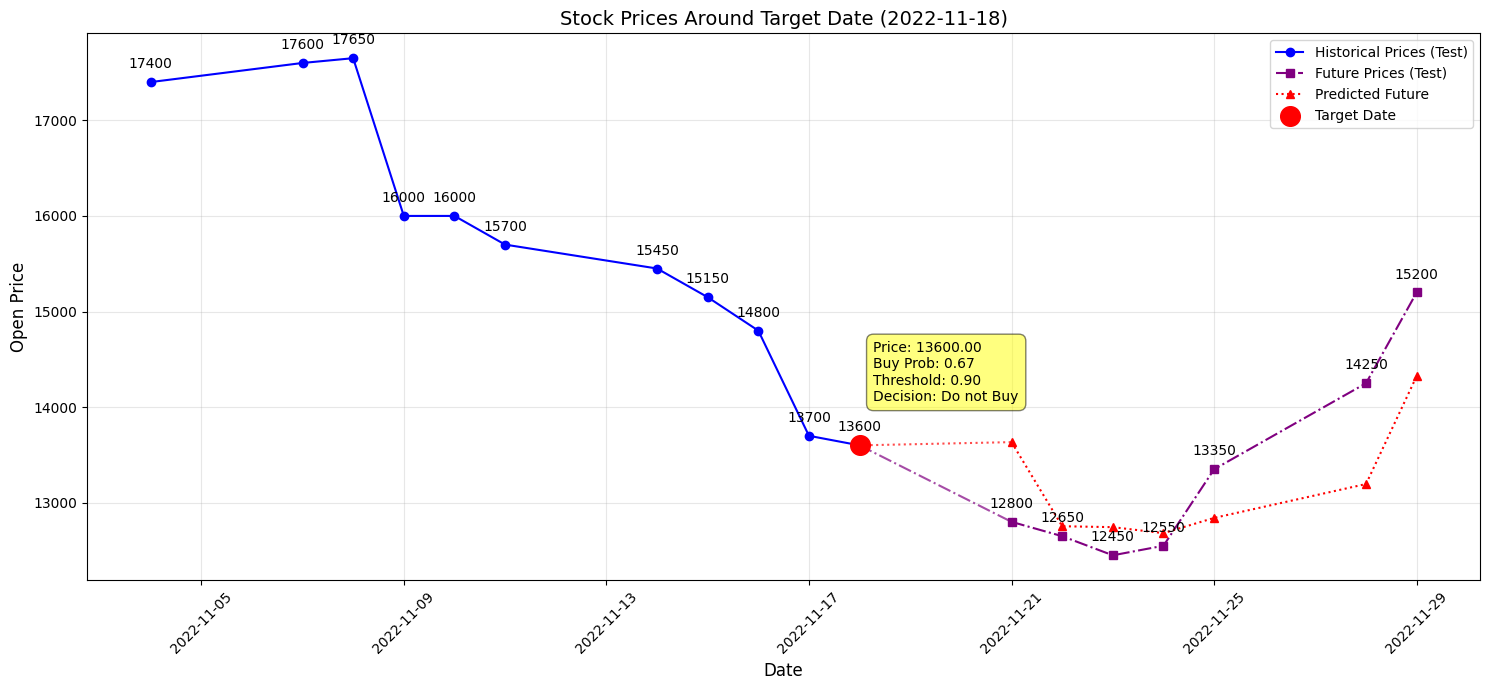


Data Points Being Plotted:
Date		Test Price	Segment		Predicted
--------------------------------------------------------------------------------
2022-11-04	17400.00		Historical		N/A
2022-11-07	17600.00		Historical		N/A
2022-11-08	17650.00		Historical		N/A
2022-11-09	16000.00		Historical		N/A
2022-11-10	16000.00		Historical		N/A
2022-11-11	15700.00		Historical		N/A
2022-11-14	15450.00		Historical		N/A
2022-11-15	15150.00		Historical		N/A
2022-11-16	14800.00		Historical		N/A
2022-11-17	13700.00		Historical		N/A
2022-11-18	13600.00		Target Date		N/A
2022-11-21	12800.00		Future		13633.87
2022-11-22	12650.00		Future		12754.13
2022-11-23	12450.00		Future		12744.47
2022-11-24	12550.00		Future		12681.54
2022-11-25	13350.00		Future		12841.30
2022-11-28	14250.00		Future		13195.69
2022-11-29	15200.00		Future		14324.93


In [ ]:
from scipy import stats

# Convert dates to datetime first
df_buy['TradingDate'] = pd.to_datetime(df_buy['TradingDate'])

# Calculate test period start and length
test_period_start = df_buy.index[-len(y_test_buy)]

# Find valid dates we can use
test_start_date = df_buy.iloc[test_period_start]['TradingDate']
test_end_date = df_buy.iloc[test_period_start + len(y_test_buy) - k_days - 1]['TradingDate']

print(f"\nValid date range for predictions:")
print(f"Test period starts at: {test_start_date.strftime('%Y-%m-%d')}")
print(f"Test period ends at: {test_end_date.strftime('%Y-%m-%d')}")

# Let's use a date in the middle of our test period as suggestion
suggested_target_idx = test_period_start + len(y_test_buy) // 4  # Using first quarter of test set
suggested_date = df_buy.iloc[suggested_target_idx]['TradingDate']

print(f"\nSuggested target date: {suggested_date.strftime('%Y-%m-%d')}")
print(f"Please use a date between {test_start_date.strftime('%Y-%m-%d')} and {test_end_date.strftime('%Y-%m-%d')}")

# Function to validate a target date
def validate_target_date(date_str):
    try:
        target_date = pd.to_datetime(date_str)
        if target_date < test_start_date or target_date > test_end_date:
            return False, "Date is outside valid range"
        if target_date not in df_buy['TradingDate'].values:
            return False, "Date is not a trading day"
        return True, "Date is valid"
    except:
        return False, "Invalid date format"

# Now you can set your target date
target_date_str = '2022-11-18'  # You can change this to any date from the valid range
is_valid, message = validate_target_date(target_date_str)

if not is_valid:
    print(f"\nError: {message}")
    print("Please choose a date from the valid range shown above.")
else:
    print(f"\nSelected date {target_date_str} is valid. Proceeding with visualization...")

    # Parameters
    past_data = 10  # For visualization
    k_days = 7  # Number of future days to predict

    # Convert target date to datetime
    target_date = pd.to_datetime(target_date_str)

    # Find the target date index
    target_idx = df_buy[df_buy['TradingDate'] == target_date].index[0]
    test_period_start = df_buy.index[-len(y_test_buy)]
    relative_target_idx = target_idx - test_period_start

    print(f"Debug info:")
    print(f"Target index in original data: {target_idx}")
    print(f"Test period starts at: {test_period_start}")
    print(f"Relative target index: {relative_target_idx}")

    # Get the dates for our window
    start_idx = max(0, target_idx - past_data)
    end_idx = min(len(df_buy), target_idx + k_days + 1)
    plot_dates = df_buy.iloc[start_idx:end_idx]['TradingDate']

    # Create masks for different segments
    historical_mask = plot_dates <= target_date
    future_mask = plot_dates > target_date

    # Calculate indices for test data
    test_start_idx = relative_target_idx - past_data
    test_end_idx = relative_target_idx + k_days + 1

    # Create the plot
    plt.figure(figsize=(15, 7))

    if test_start_idx >= 0 and relative_target_idx < len(y_test_buy):
        # Plot historical data from test set
        historical_data = y_test_buy[test_start_idx:relative_target_idx+1, 0]
        plt.plot(plot_dates[historical_mask],
                 historical_data,
                 color='blue', label='Historical Prices (Test)', marker='o')

        # Plot future data from test set
        future_data = y_test_buy[relative_target_idx+1:test_end_idx, 0]
        future_dates = plot_dates[future_mask]

        # Get target date value for connecting lines
        target_value = y_test_buy[relative_target_idx, 0]

        # Connect target date to first future point (test data)
        plt.plot([target_date, future_dates.iloc[0]],
                 [target_value, future_data[0]],
                 color='purple', linestyle='-.', alpha=0.7)

        plt.plot(future_dates,
                 future_data,
                 color='purple', label='Future Prices (Test)', marker='s', linestyle='-.')

        # Plot predicted future
        pred_indices = np.arange(relative_target_idx + 1, relative_target_idx + len(future_dates) + 1)
        future_predictions = y_pred_denorm_buy[pred_indices, 0]

        # Connect target date to first prediction
        plt.plot([target_date, future_dates.iloc[0]],
                 [target_value, future_predictions[0]],
                 color='red', linestyle=':', alpha=0.7)

        plt.plot(future_dates,
                 future_predictions,
                 color='red', label='Predicted Future', marker='^', linestyle=':')

        # Calculate buy signal
        time_window_data = y_test_buy[test_start_idx:test_end_idx, 0]
        target_price = y_test_buy[relative_target_idx, 0]
        percentile = stats.percentileofscore(time_window_data, target_price)
        buy_probability = (100 - percentile) / 100
        is_buy = percentile <= 10

        # Mark target date
        plt.scatter(target_date, target_price,
                   color='red', s=200, label='Target Date', zorder=5)

        # Add price annotations
        for date, price in zip(plot_dates[historical_mask], historical_data):
            plt.annotate(f'{price:.0f}',
                        (date, price),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center')

        for date, price in zip(future_dates, future_data):
            plt.annotate(f'{price:.0f}',
                        (date, price),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center')

        # Add buy signal information box
        info_text = (f'Price: {target_price:.2f}\n'
                    f'Buy Prob: {buy_probability:.2f}\n'
                    f'Threshold: 0.90\n'
                    f'Decision: {"Buy" if is_buy else "Do not Buy"}')
        plt.annotate(info_text,
                    (target_date, target_price),
                    xytext=(10, 30),
                    textcoords='offset points',
                    bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'),
                    ha='left',
                    va='bottom')

    # Customize the plot
    plt.title(f'Stock Prices Around Target Date ({target_date_str})', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Open Price', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print analysis
    print("\nData Points Being Plotted:")
    print("Date\t\tTest Price\tSegment\t\tPredicted")
    print("-" * 80)
    for i, date in enumerate(plot_dates):
        if date <= target_date:
            segment = "Target Date" if date == target_date else "Historical"
            price = y_test_buy[test_start_idx + i, 0]
            print(f"{date.strftime('%Y-%m-%d')}\t{price:.2f}\t\t{segment}\t\tN/A")
        else:
            segment = "Future"
            test_price = y_test_buy[test_start_idx + i, 0]
            pred_idx = relative_target_idx + (i - len(historical_data)) + 1
            pred_price = y_pred_denorm_buy[pred_idx, 0]
            print(f"{date.strftime('%Y-%m-%d')}\t{test_price:.2f}\t\t{segment}\t\t{pred_price:.2f}")

# **Selling Signal Identification**

# **Testing Selling Signal Algorithm With Available Model**

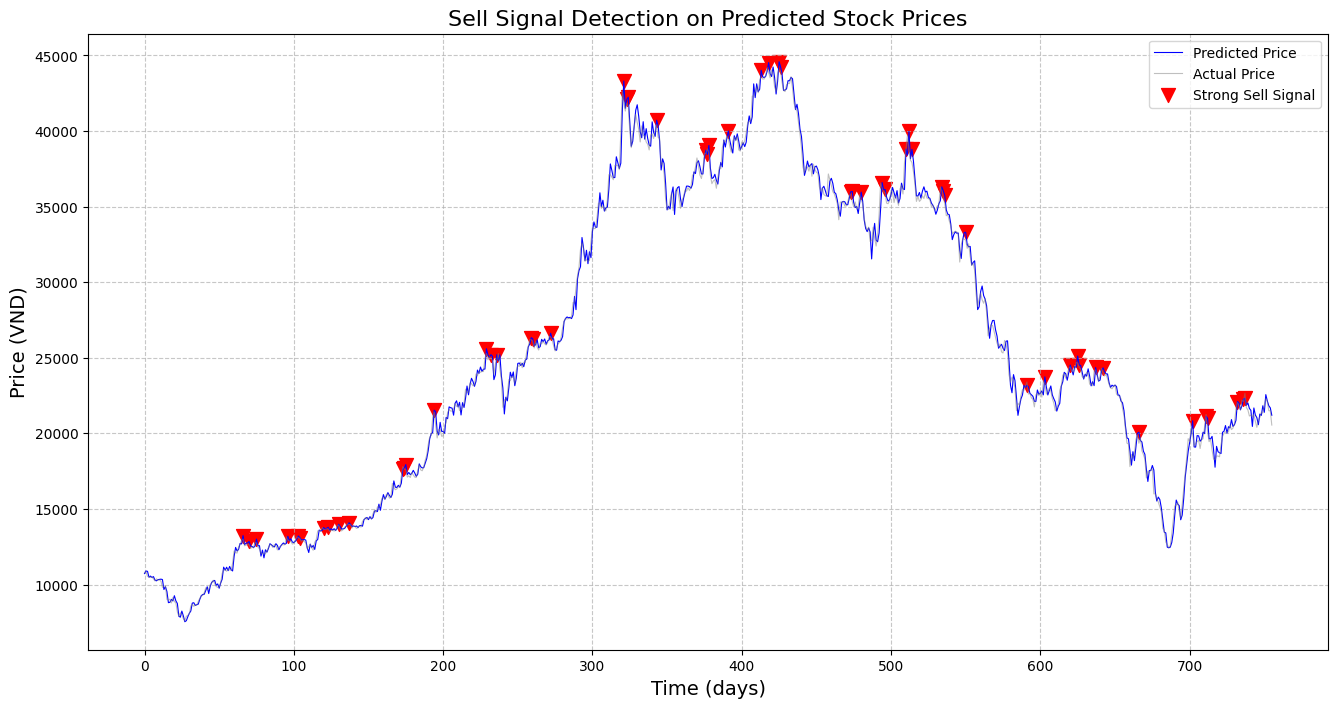


Number of sell signals detected: 58
Average predicted price at sell signals: 28022.63
Average actual price at sell signals: 27716.068965517243


In [ ]:
# Create a DataFrame with both predicted and actual prices
df_analysis = pd.DataFrame({
    'Open': y_pred_denorm.flatten(),  # Using predicted prices
    'Real_Open': y_test.flatten()  # Actual prices for reference
})

# Define the time window size
window_size = 20  # Ensure an odd number to have the "present point" in the middle
k_days_future = 7  # Forecast k days into the future

# Add a column for Sell Signal Probability
df_analysis['Sell_Prob'] = 0.0  # Initialize with 0

# Add a smoothed predicted price column (7-day moving average)
df_analysis['Smoothed_Open'] = df_analysis['Open'].rolling(window=7).mean()

# Define a global price threshold for "high prices" based on predicted prices
global_threshold = np.percentile(df_analysis['Open'], 90)  # Top 10% of predicted prices

# Iterate through the dataset, leaving margins for the window
for i in range(window_size // 2, len(df_analysis) - window_size // 2 - k_days_future):
    # Define the time window indices
    start_idx = i - window_size // 2
    end_idx = i + window_size // 2 + 1
    time_window = df_analysis.iloc[start_idx:end_idx]['Open']

    # Get the "present point" predicted price
    present_price = df_analysis.iloc[i]['Open']

    # Calculate the threshold for this window
    threshold = np.percentile(time_window, 90)  # Top 10% threshold

    # Check if the present price is in the top 10% and above the moving average
    if (present_price >= threshold) and (present_price > df_analysis.iloc[i]['Smoothed_Open']):
        df_analysis.at[i, 'Sell_Prob'] = 1.0  # Strong sell signal
    else:
        # Probability score relative to price position in the range
        df_analysis.at[i, 'Sell_Prob'] = max(0, (present_price - time_window.min()) /
                                           (time_window.max() - time_window.min()))

# Visualization
plt.figure(figsize=(16, 8))

# Plot predicted prices
plt.plot(df_analysis['Open'], label='Predicted Price', color='blue', linewidth=0.8)

# Plot actual prices
plt.plot(df_analysis['Real_Open'], label='Actual Price', color='gray', alpha=0.5, linewidth=0.8)

# Add markers for Sell Signals
sell_signals = df_analysis[df_analysis['Sell_Prob'] == 1.0]
plt.scatter(
    sell_signals.index,
    sell_signals['Open'],
    color='red',
    label='Strong Sell Signal',
    marker='v',  # Downward-pointing triangle
    s=100
)

# Enhance the visualization
plt.title(f'Sell Signal Detection on Predicted Stock Prices', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Price (VND)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Print some statistics
print("\nNumber of sell signals detected:", len(sell_signals))
if len(sell_signals) > 0:
    print("Average predicted price at sell signals:", sell_signals['Open'].mean())
    print("Average actual price at sell signals:", sell_signals['Real_Open'].mean())

# **Selling Signal - Specific Trading Date**

In [ ]:
# Load stock data with distinct function name
def load_stock_data_consecutive(stock_ticker):
    # Try each possible index pattern
    index_patterns = ['-VNINDEX-', '-HNXIndex-', '-UpcomIndex-']

    for pattern in index_patterns:
        try:
            file_path = f"/content/vn_data/stock-historical-data/{ticker}{pattern}History.csv"
            df = pd.read_csv(file_path)
            print(f"Loaded {ticker} data from {file_path}")
            return df
        except FileNotFoundError:
            continue

    # If no file is found with any pattern
    raise FileNotFoundError(f"No data file found for ticker {ticker} with any known index pattern")

# Define stock ticker
stock_ticker = 'HPG'  # Can be changed to any stock
df_sell = load_stock_data_consecutive(stock_ticker)

### Split dataset for sell signal prediction
X_data_sell = []
y_data_sell = []
label_index_sell = 2  # Open price as label
window_size_sell = 30  # Time window
k_days = 7  # Predict next k consecutive days

# Get features and k consecutive days labels
for i in range(0, len(df_sell) - window_size_sell - k_days):
    data_feature_sell = []
    data_label_sell = []

    # Get window_size time frame for features
    for j in range(window_size_sell):
        features_sell = []
        features_sell.append(df_sell.iloc[i + j, 1])  # Low
        features_sell.append(df_sell.iloc[i + j, 2])  # Open
        features_sell.append(df_sell.iloc[i + j, 4])  # High
        features_sell.append(df_sell.iloc[i + j, 5])  # Close
        features_sell.append(df_sell.iloc[i + j, 3])  # Volume
        data_feature_sell.append(features_sell)

    # Get next k consecutive days as labels
    for j in range(k_days):
        data_label_sell.append(df_sell.iloc[i + window_size_sell + j, label_index_sell])

    X_data_sell.append(np.array(data_feature_sell).reshape(window_size_sell, 5))
    y_data_sell.append(np.array(data_label_sell))

### Split into training, validation and test sets
from sklearn.model_selection import train_test_split

X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(X_data_sell, y_data_sell, test_size=0.2, shuffle=False)
X_train_sell, X_val_sell, y_train_sell, y_val_sell = train_test_split(X_train_sell, y_train_sell, test_size=0.2, shuffle=False)

# Convert to Numpy arrays
X_train_sell = np.array(X_train_sell)
X_val_sell = np.array(X_val_sell)
X_test_sell = np.array(X_test_sell)
y_train_sell = np.array(y_train_sell)
y_val_sell = np.array(y_val_sell)
y_test_sell = np.array(y_test_sell)

# Reshape arrays
X_train_sell = X_train_sell.reshape(X_train_sell.shape[0], window_size_sell, 5)
X_val_sell = X_val_sell.reshape(X_val_sell.shape[0], window_size_sell, 5)
X_test_sell = X_test_sell.reshape(X_test_sell.shape[0], window_size_sell, 5)

### MinMax normalize training data
X_train_norm_sell = X_train_sell.copy()
y_train_norm_sell = y_train_sell.copy()

for i in range(0, len(X_train_sell)):
    for j in range(0, len(X_train_sell[0][0])):
        min_feature_sell = np.min(X_train_sell[i][:, j])
        max_feature_sell = np.max(X_train_sell[i][:, j])
        X_train_norm_sell[i][:, j] = (X_train_sell[i][:, j] - min_feature_sell) / (max_feature_sell - min_feature_sell)

    min_feature_label_sell = np.min(X_train_sell[i][:, label_index_sell - 1])
    max_feature_label_sell = np.max(X_train_sell[i][:, label_index_sell - 1])
    y_train_norm_sell[i] = (y_train_sell[i] - min_feature_label_sell) / (max_feature_label_sell - min_feature_label_sell)

### MinMax normalize validation data
X_val_norm_sell = X_val_sell.copy()
y_val_norm_sell = y_val_sell.copy()

for i in range(0, len(X_val_sell)):
    for j in range(0, len(X_val_sell[0][0])):
        min_feature_sell = np.min(X_val_sell[i][:, j])
        max_feature_sell = np.max(X_val_sell[i][:, j])
        X_val_norm_sell[i][:, j] = (X_val_sell[i][:, j] - min_feature_sell) / (max_feature_sell - min_feature_sell)

    min_feature_label_sell = np.min(X_val_sell[i][:, label_index_sell - 1])
    max_feature_label_sell = np.max(X_val_sell[i][:, label_index_sell - 1])
    y_val_norm_sell[i] = (y_val_sell[i] - min_feature_label_sell) / (max_feature_label_sell - min_feature_label_sell)

### MinMax normalize test data
X_test_norm_sell = X_test_sell.copy()
y_test_norm_sell = y_test_sell.copy()

for i in range(0, len(X_test_sell)):
    for j in range(0, len(X_test_sell[0][0])):
        min_feature_sell = np.min(X_test_sell[i][:, j])
        max_feature_sell = np.max(X_test_sell[i][:, j])
        X_test_norm_sell[i][:, j] = (X_test_sell[i][:, j] - min_feature_sell) / (max_feature_sell - min_feature_sell)

    min_feature_label_sell = np.min(X_test_sell[i][:, label_index_sell - 1])
    max_feature_label_sell = np.max(X_test_sell[i][:, label_index_sell - 1])
    y_test_norm_sell[i] = (y_test_sell[i] - min_feature_label_sell) / (max_feature_label_sell - min_feature_label_sell)
### Create and train sell signal model
model_sell = tf.keras.Sequential()
model_sell.add(LSTM(units=32, return_sequences=True, input_shape=(window_size_sell, 5)))
model_sell.add(LSTM(units=64))
model_sell.add(Dense(100, activation='relu'))
model_sell.add(Dense(k_days))  # Output layer has k_days units for consecutive predictions

model_checkpoint_sell = ModelCheckpoint(
    f'best_model_vietnam_sell.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_sell = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_sell = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

model_sell.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                   loss='mse',
                   metrics=['mse'])

history_sell = model_sell.fit(X_train_norm_sell, y_train_norm_sell,
                              validation_data=(X_val_norm_sell, y_val_norm_sell),
                              epochs=30, batch_size=512,
                              callbacks=[early_stopping_sell, model_checkpoint_sell, reduce_lr_sell])

### Evaluate on test data and calculate MSE for each day
y_pred_norm_sell = model_sell.predict(X_test_norm_sell)
for day in range(k_days):
    mse = mean_squared_error(y_test_norm_sell[:, day], y_pred_norm_sell[:, day])
    print(f"MSE for day {day+1}: {mse}")

# Denormalize predictions
y_pred_denorm_sell = y_pred_norm_sell.copy()
for i in range(0, len(y_pred_denorm_sell)):
    min_feature_label_sell = np.min(X_test_sell[i][:, label_index_sell - 1])
    max_feature_label_sell = np.max(X_test_sell[i][:, label_index_sell - 1])
    y_pred_denorm_sell[i] = y_pred_norm_sell[i] * (max_feature_label_sell - min_feature_label_sell) + min_feature_label_sell


Loaded HPG data from /content/vn_data/stock-historical-data/HPG-VNINDEX-History.csv
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.5820 - mse: 0.5820
Epoch 1: val_loss improved from inf to 0.28019, saving model to best_model_vietnam_sell.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.4818 - mse: 0.4818 - val_loss: 0.2802 - val_mse: 0.2802 - learning_rate: 0.0100
Epoch 2/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - loss: 0.3486 - mse: 0.3486
Epoch 2: val_loss improved from 0.28019 to 0.18122, saving model to best_model_vietnam_sell.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2941 - mse: 0.2941 - val_loss: 0.1812 - val_mse: 0.1812 - learning_rate: 0.0100
Epoch 3/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.2315 - mse: 0.2315
Epoch 3: val_loss improved from 0.18122 to 0.15132, saving model to best_model_vietnam_sell.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2134 - mse: 0.2134 - val_loss: 0.1513 - val_mse: 0.1513 - learning_rate: 0.0100
Epoch 4/30
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1687 - mse: 0.1687
Epoch 4: val_loss improve


Valid date range for predictions:
Test period starts at: 2020-02-24
Test period ends at: 2023-02-17

Suggested target date: 2020-11-18
Please use a date between 2020-02-24 and 2023-02-17

Selected date 2022-11-18 is valid. Proceeding with visualization...
Debug info:
Target index in original data: 3742
Test period starts at: 3054
Relative target index: 688


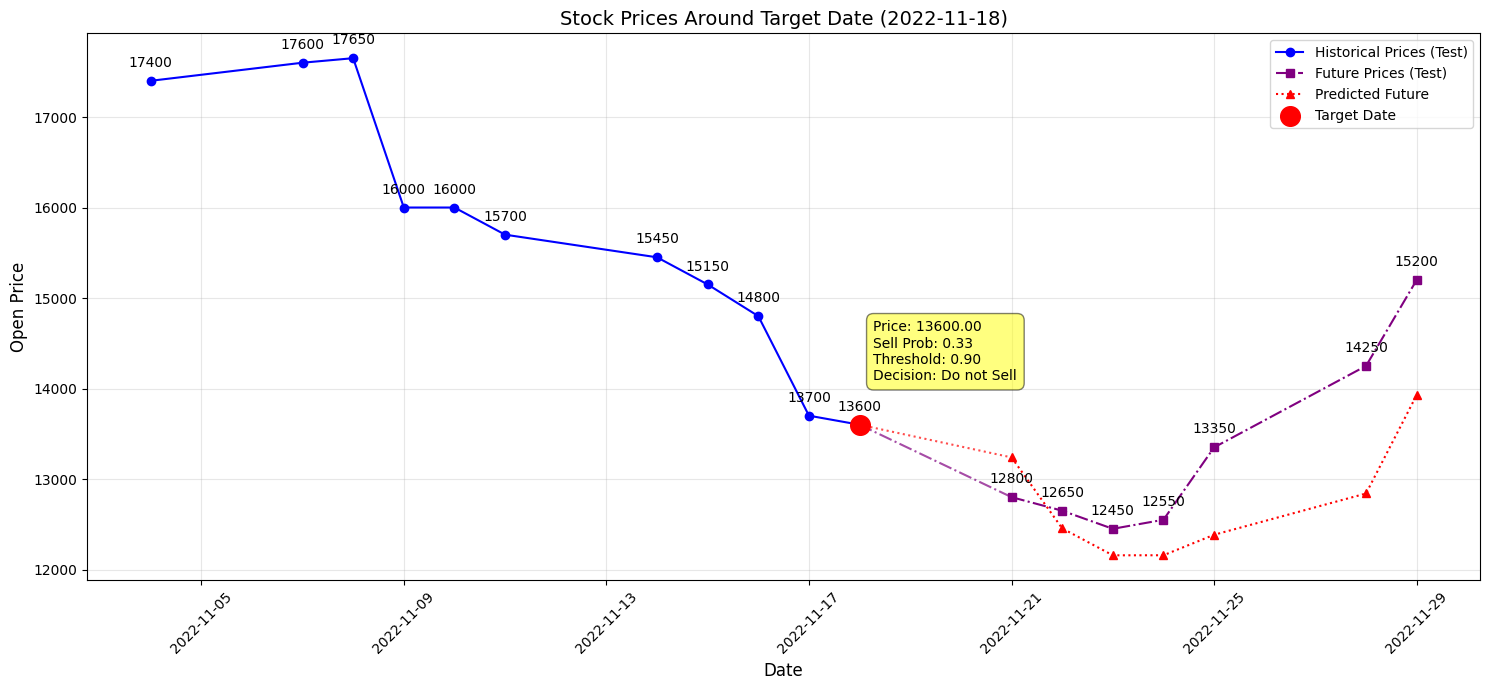


Data Points Being Plotted:
Date		Test Price	Segment		Predicted
--------------------------------------------------------------------------------
2022-11-04	17400.00		Historical		N/A
2022-11-07	17600.00		Historical		N/A
2022-11-08	17650.00		Historical		N/A
2022-11-09	16000.00		Historical		N/A
2022-11-10	16000.00		Historical		N/A
2022-11-11	15700.00		Historical		N/A
2022-11-14	15450.00		Historical		N/A
2022-11-15	15150.00		Historical		N/A
2022-11-16	14800.00		Historical		N/A
2022-11-17	13700.00		Historical		N/A
2022-11-18	13600.00		Target Date		N/A
2022-11-21	12800.00		Future		13239.14
2022-11-22	12650.00		Future		12454.83
2022-11-23	12450.00		Future		12157.26
2022-11-24	12550.00		Future		12157.86
2022-11-25	13350.00		Future		12384.29
2022-11-28	14250.00		Future		12840.21
2022-11-29	15200.00		Future		13928.91


In [ ]:
# Convert dates to datetime first
df_sell['TradingDate'] = pd.to_datetime(df_sell['TradingDate'])

# Calculate test period start and length
test_period_start = df_sell.index[-len(y_test_sell)]

# Find valid dates we can use
test_start_date = df_sell.iloc[test_period_start]['TradingDate']
test_end_date = df_sell.iloc[test_period_start + len(y_test_sell) - k_days - 1]['TradingDate']

print(f"\nValid date range for predictions:")
print(f"Test period starts at: {test_start_date.strftime('%Y-%m-%d')}")
print(f"Test period ends at: {test_end_date.strftime('%Y-%m-%d')}")

# Let's use a date in the middle of our test period as suggestion
suggested_target_idx = test_period_start + len(y_test_sell) // 4  # Using first quarter of test set
suggested_date = df_sell.iloc[suggested_target_idx]['TradingDate']

print(f"\nSuggested target date: {suggested_date.strftime('%Y-%m-%d')}")
print(f"Please use a date between {test_start_date.strftime('%Y-%m-%d')} and {test_end_date.strftime('%Y-%m-%d')}")

# Function to validate a target date
def validate_target_date(date_str):
    try:
        target_date = pd.to_datetime(date_str)
        if target_date < test_start_date or target_date > test_end_date:
            return False, "Date is outside valid range"
        if target_date not in df_sell['TradingDate'].values:
            return False, "Date is not a trading day"
        return True, "Date is valid"
    except:
        return False, "Invalid date format"

# Now you can set your target date
target_date_str = '2022-11-18'  # You can change this to any date from the valid range
is_valid, message = validate_target_date(target_date_str)

if not is_valid:
    print(f"\nError: {message}")
    print("Please choose a date from the valid range shown above.")
else:
    print(f"\nSelected date {target_date_str} is valid. Proceeding with visualization...")

    # Parameters
    past_data = 10  # For visualization
    k_days = 7  # Number of future days to predict

    # Convert target date to datetime
    target_date = pd.to_datetime(target_date_str)

    # Find the target date index
    target_idx = df_sell[df_sell['TradingDate'] == target_date].index[0]
    test_period_start = df_sell.index[-len(y_test_sell)]
    relative_target_idx = target_idx - test_period_start

    print(f"Debug info:")
    print(f"Target index in original data: {target_idx}")
    print(f"Test period starts at: {test_period_start}")
    print(f"Relative target index: {relative_target_idx}")

    # Get the dates for our window
    start_idx = max(0, target_idx - past_data)
    end_idx = min(len(df_sell), target_idx + k_days + 1)
    plot_dates = df_sell.iloc[start_idx:end_idx]['TradingDate']

    # Create masks for different segments
    historical_mask = plot_dates <= target_date
    future_mask = plot_dates > target_date

    # Calculate indices for test data
    test_start_idx = relative_target_idx - past_data
    test_end_idx = relative_target_idx + k_days + 1

    # Create the plot
    plt.figure(figsize=(15, 7))

    if test_start_idx >= 0 and relative_target_idx < len(y_test_sell):
        # Plot historical data from test set
        historical_data = y_test_sell[test_start_idx:relative_target_idx+1, 0]
        plt.plot(plot_dates[historical_mask],
                 historical_data,
                 color='blue', label='Historical Prices (Test)', marker='o')

        # Plot future data from test set
        future_data = y_test_sell[relative_target_idx+1:test_end_idx, 0]
        future_dates = plot_dates[future_mask]

        # Get target date value for connecting lines
        target_value = y_test_sell[relative_target_idx, 0]

        # Connect target date to first future point (test data)
        plt.plot([target_date, future_dates.iloc[0]],
                 [target_value, future_data[0]],
                 color='purple', linestyle='-.', alpha=0.7)

        plt.plot(future_dates,
                 future_data,
                 color='purple', label='Future Prices (Test)', marker='s', linestyle='-.')

        # Plot predicted future
        pred_indices = np.arange(relative_target_idx + 1, relative_target_idx + len(future_dates) + 1)
        future_predictions = y_pred_denorm_sell[pred_indices, 0]

        # Connect target date to first prediction
        plt.plot([target_date, future_dates.iloc[0]],
                 [target_value, future_predictions[0]],
                 color='red', linestyle=':', alpha=0.7)

        plt.plot(future_dates,
                 future_predictions,
                 color='red', label='Predicted Future', marker='^', linestyle=':')

        # Calculate sell signal
        time_window_data = y_test_sell[test_start_idx:test_end_idx, 0]
        target_price = y_test_sell[relative_target_idx, 0]
        percentile = stats.percentileofscore(time_window_data, target_price)
        sell_probability = percentile / 100
        is_sell = percentile >= 90

        # Mark target date
        plt.scatter(target_date, target_price,
                   color='red', s=200, label='Target Date', zorder=5)

        # Add price annotations
        for date, price in zip(plot_dates[historical_mask], historical_data):
            plt.annotate(f'{price:.0f}',
                        (date, price),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center')

        for date, price in zip(future_dates, future_data):
            plt.annotate(f'{price:.0f}',
                        (date, price),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center')

        # Add sell signal information box
        info_text = (f'Price: {target_price:.2f}\n'
                    f'Sell Prob: {sell_probability:.2f}\n'
                    f'Threshold: 0.90\n'
                    f'Decision: {"Sell" if is_sell else "Do not Sell"}')
        plt.annotate(info_text,
                    (target_date, target_price),
                    xytext=(10, 30),
                    textcoords='offset points',
                    bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'),
                    ha='left',
                    va='bottom')

    # Customize the plot
    plt.title(f'Stock Prices Around Target Date ({target_date_str})', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Open Price', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print analysis
    print("\nData Points Being Plotted:")
    print("Date\t\tTest Price\tSegment\t\tPredicted")
    print("-" * 80)
    for i, date in enumerate(plot_dates):
        if date <= target_date:
            segment = "Target Date" if date == target_date else "Historical"
            price = y_test_sell[test_start_idx + i, 0]
            print(f"{date.strftime('%Y-%m-%d')}\t{price:.2f}\t\t{segment}\t\tN/A")
        else:
            segment = "Future"
            test_price = y_test_sell[test_start_idx + i, 0]
            pred_idx = relative_target_idx + (i - len(historical_data)) + 1
            pred_price = y_pred_denorm_sell[pred_idx, 0]
            print(f"{date.strftime('%Y-%m-%d')}\t{test_price:.2f}\t\t{segment}\t\t{pred_price:.2f}")


# **Portfolio Composition**

# **Most Profitable**

In [ ]:
# Load stock data with different exchange patterns
def load_stock_data(ticker):
   index_patterns = ['-VNINDEX-', '-HNXIndex-', '-UpcomIndex-']

   for pattern in index_patterns:
       try:
           file_path = f"/content/vn_data/stock-historical-data/{ticker}{pattern}History.csv"
           df = pd.read_csv(file_path)
           return df
       except FileNotFoundError:
           continue
   raise FileNotFoundError(f"No data file found for ticker {ticker}")

def filter_companies(min_data_points=120, exchanges=None, industries=None):
   ticker_overview = pd.read_csv("/content/vn_data/ticker-overview.csv")
   filtered_companies = []

   for _, company in ticker_overview.iterrows():
       ticker = company['ticker']
       try:
           df = load_stock_data(ticker)
           if len(df) < min_data_points:
               continue
           if exchanges and company['exchange'] not in exchanges:
               continue
           if industries and company['industry'] not in industries:
               continue
           filtered_companies.append(ticker)
       except FileNotFoundError:
           continue
   return filtered_companies

# Filter companies with minimum criteria
exchanges = ['HOSE', 'HNX']
min_points = 120
companies_list = filter_companies(min_data_points=min_points, exchanges=exchanges)

# Analyze each company's:
# 1. Average daily trading volume (liquidity)
# 2. Price trend (7-day moving average)
# 3. Return over last 30 days
# 4. Volatility (risk measure)

portfolio_analysis = []

for ticker in companies_list:
   try:
       # Load stock data
       df = load_stock_data(ticker)

       # Convert TradingDate to datetime
       df['TradingDate'] = pd.to_datetime(df['TradingDate'])

       # Sort by date
       df = df.sort_values('TradingDate')

       # Calculate metrics for last 30 trading days
       last_30_days = df.tail(30)

       # Calculate metrics
       avg_volume = last_30_days['Volume'].mean()
       price_trend = (last_30_days['Close'].mean() - last_30_days['Open'].mean()) / last_30_days['Open'].mean() * 100
       total_return = (last_30_days['Close'].iloc[-1] - last_30_days['Close'].iloc[0]) / last_30_days['Close'].iloc[0] * 100
       volatility = last_30_days['Close'].std() / last_30_days['Close'].mean() * 100

       # Add to analysis list
       portfolio_analysis.append({
           'ticker': ticker,
           'avg_volume': avg_volume,
           'price_trend': price_trend,
           'return_30d': total_return,
           'volatility': volatility,
           'last_price': last_30_days['Close'].iloc[-1]
       })

   except Exception as e:
       print(f"Error processing {ticker}: {str(e)}")
       continue

# Convert to DataFrame
portfolio_df = pd.DataFrame(portfolio_analysis)

# Score each company based on metrics
portfolio_df['volume_score'] = (portfolio_df['avg_volume'] - portfolio_df['avg_volume'].min()) / (portfolio_df['avg_volume'].max() - portfolio_df['avg_volume'].min())
portfolio_df['trend_score'] = (portfolio_df['price_trend'] - portfolio_df['price_trend'].min()) / (portfolio_df['price_trend'].max() - portfolio_df['price_trend'].min())
portfolio_df['return_score'] = (portfolio_df['return_30d'] - portfolio_df['return_30d'].min()) / (portfolio_df['return_30d'].max() - portfolio_df['return_30d'].min())
portfolio_df['risk_score'] = 1 - (portfolio_df['volatility'] - portfolio_df['volatility'].min()) / (portfolio_df['volatility'].max() - portfolio_df['volatility'].min())

# Calculate total score (equal weighting)
portfolio_df['total_score'] = (portfolio_df['volume_score'] +
                            portfolio_df['trend_score'] +
                            portfolio_df['return_score'] +
                            portfolio_df['risk_score']) / 4

# Sort by total score and get top 20 companies
top_companies = portfolio_df.nlargest(20, 'total_score')

# Print detailed information about top companies
print("\nTop 20 Companies Analysis:")
print(top_companies[['ticker', 'last_price', 'return_30d', 'volatility', 'total_score']].to_string())

# Save results to CSV
top_companies.to_csv('portfolio_composition.csv', index=False)


Top 20 Companies Analysis:
    ticker  last_price  return_30d  volatility  total_score
265    HPG     20000.0   -0.990099    3.118964     0.694258
268    HSG     14550.0   11.068702    5.408786     0.608811
719    VND     13450.0   -8.813559    6.198551     0.590374
563    STB     23750.0   -3.846154    4.156955     0.582642
732    VPB     17050.0   -7.588076    5.169642     0.580750
560    SSI     18250.0   -5.440415    4.382911     0.558086
529    SHB      9790.0   -7.203791    4.182587     0.550777
450    PPS     11500.0    8.490566    3.611194     0.550373
476    POW     12100.0    3.862661    2.035985     0.534296
477    PVS     26000.0   13.537118    4.608588     0.529722
392    NKG     14150.0    1.798561    5.584167     0.529254
350    LPB     13950.0   -3.460208    3.266071     0.524584
534    SHS      8100.0  -10.989011    6.280846     0.524317
336    LCG     11450.0   31.912442   10.808364     0.524046
632    TPB     23300.0    3.786192    3.124205     0.523261
472    PVI  

# **Task 4.2 - Risk management**

In [ ]:
# Load stock data with different exchange patterns
def load_stock_data(ticker):
   index_patterns = ['-VNINDEX-', '-HNXIndex-', '-UpcomIndex-']

   for pattern in index_patterns:
       try:
           file_path = f"/content/vn_data/stock-historical-data/{ticker}{pattern}History.csv"
           df = pd.read_csv(file_path)
           return df
       except FileNotFoundError:
           continue
   raise FileNotFoundError(f"No data file found for ticker {ticker}")

def filter_companies(min_data_points=120, exchanges=None, industries=None):
   ticker_overview = pd.read_csv("/content/vn_data/ticker-overview.csv")
   filtered_companies = []

   for _, company in ticker_overview.iterrows():
       ticker = company['ticker']
       try:
           df = load_stock_data(ticker)
           if len(df) < min_data_points:
               continue
           if exchanges and company['exchange'] not in exchanges:
               continue
           if industries and company['industry'] not in industries:
               continue
           filtered_companies.append(ticker)
       except FileNotFoundError:
           continue
   return filtered_companies

# Filter companies with minimum criteria
exchanges = ['HOSE', 'HNX']
min_points = 120
companies_list = filter_companies(min_data_points=min_points, exchanges=exchanges)

# Analyze each company's:
# 1. Average daily trading volume (liquidity)
# 2. Price trend (7-day moving average)
# 3. Return over last 30 days
# 4. Volatility (risk measure)

risk_analysis = []

for ticker in companies_list:
    try:
        # Load stock data
        df = load_stock_data(ticker)

        # Convert TradingDate to datetime
        df['TradingDate'] = pd.to_datetime(df['TradingDate'])

        # Sort by date
        df = df.sort_values('TradingDate')

        # Calculate market-based risk metrics for last 60 trading days
        last_60_days = df.tail(60)

        # 1. Price Volatility (higher = riskier)
        volatility = last_60_days['Close'].std() / last_60_days['Close'].mean() * 100

        # 2. Downside Deviation (focuses on negative returns)
        daily_returns = last_60_days['Close'].pct_change()
        downside_returns = daily_returns[daily_returns < 0]
        downside_deviation = downside_returns.std() * 100

        # 3. Volume Volatility (unstable trading volume = riskier)
        mean_volume = last_60_days['Volume'].mean()
        if mean_volume > 0:
            volume_volatility = last_60_days['Volume'].std() / mean_volume * 100
        else:
            volume_volatility = 0
        # 4. Price Drawdown (maximum price drop)
        rolling_max = last_60_days['Close'].rolling(window=60, min_periods=1).max()
        drawdown = ((last_60_days['Close'] - rolling_max) / rolling_max).min() * 100

        # 5. Load financial ratios for the company
        try:
            # Try different exchange patterns
            exchange_patterns = ['-VNINDEX-', '-HNXIndex-', '-UpcomIndex-']

            for pattern in exchange_patterns:
                try:
                    ratio_path = f"/content/vn_data/financial-ratio/{ticker}{pattern}Finance.csv"
                    company_ratios = pd.read_csv(ratio_path)
                    if not company_ratios.empty:
                        # Take the latest values directly from the columns
                        latest_ratios = company_ratios.iloc[-1]
                        debt_to_equity = latest_ratios['debtOnEquity']
                        debt_to_asset = latest_ratios['debtOnAsset']
                        quick_ratio = latest_ratios['quickPayment']
                        current_ratio = latest_ratios['currentPayment']
                        roe = latest_ratios['roe']
                        roa = latest_ratios['roa']
                        break
                except:
                    continue

            if 'company_ratios' not in locals():
                raise FileNotFoundError(f"No financial ratio data found for {ticker}")

        except Exception as e:
            print(f"Error loading financial ratios for {ticker}: {str(e)}")
            debt_to_equity = debt_to_asset = quick_ratio = current_ratio = roe = roa = 0

        # Add to risk analysis list
        risk_analysis.append({
            'ticker': ticker,
            'price_volatility': volatility,
            'downside_deviation': downside_deviation,
            'volume_volatility': volume_volatility,
            'max_drawdown': abs(drawdown),
            'debt_to_equity': debt_to_equity,
            'debt_to_asset': debt_to_asset,
            'quick_ratio': quick_ratio,
            'current_ratio': current_ratio,
            'roe': roe,
            'roa': roa,
            'last_price': last_60_days['Close'].iloc[-1]
        })

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        continue

# Convert to DataFrame
risk_df = pd.DataFrame(risk_analysis)
risk_df = risk_df.fillna(0)

# Score each risk factor (higher score = riskier)
risk_factors = ['price_volatility', 'downside_deviation', 'volume_volatility',
                'max_drawdown', 'debt_to_equity', 'debt_to_asset']
protection_factors = ['quick_ratio', 'current_ratio', 'roe', 'roa']

# Normalize risk factors (higher value = higher risk)
for factor in risk_factors:
    risk_df[f'{factor}_score'] = (risk_df[factor] - risk_df[factor].min()) / (risk_df[factor].max() - risk_df[factor].min())

# Normalize protection factors (higher value = lower risk)
for factor in protection_factors:
    risk_df[f'{factor}_score'] = 1 - (risk_df[factor] - risk_df[factor].min()) / (risk_df[factor].max() - risk_df[factor].min())

# Calculate total risk score
risk_df['total_risk_score'] = risk_df[[col for col in risk_df.columns if col.endswith('_score')]].mean(axis=1)

# Sort by risk score and get the riskiest companies
risky_companies = risk_df.nlargest(20, 'total_risk_score')

# Print detailed information about riskiest companies
print("\nTop 20 Riskiest Companies Analysis:")
print(risky_companies[['ticker', 'last_price', 'price_volatility', 'max_drawdown', 'debt_to_equity', 'total_risk_score']].to_string())


Top 20 Riskiest Companies Analysis:
    ticker  last_price  price_volatility  max_drawdown  debt_to_equity  total_risk_score
333    LBE     20000.0         32.432348     49.695122             0.1          0.615161
283    IBC      2670.0         50.356514     78.348624             0.4          0.606658
331    LAF     15400.0          6.425533     20.972644             4.0          0.598500
745    VTL     13800.0          5.116561      9.803922             2.8          0.597925
642    TSB     34400.0         50.489317     26.495726             2.3          0.591531
713    VMC      8900.0          7.687310     11.881188             6.3          0.591436
309    KKC      7800.0         13.394372     41.860465             1.9          0.588940
452    PSC     12600.0          6.530528     22.839506             2.4          0.586801
123    CTT     14000.0          4.772804      9.090909             7.6          0.582256
258    HLC     10000.0         14.100043     17.500000             5.4   

In [ ]:
# Save results to CSV
risky_companies.to_csv('risk_assessment.csv', index=False)

# Calculate and print risk score distribution statistics
print("\nRisk Score Distribution Statistics:")
print(risk_df['total_risk_score'].describe())


Risk Score Distribution Statistics:
count    754.000000
mean       0.434074
std        0.061404
min        0.204012
25%        0.398871
50%        0.432709
75%        0.472400
max        0.615161
Name: total_risk_score, dtype: float64


# **Task 4.3 - Portfolio optimization**

In [ ]:
from scipy.optimize import minimize

# Load the results from previous tasks
profitable_companies = pd.read_csv('portfolio_composition.csv')
risk_assessment = pd.read_csv('risk_assessment.csv')

# Filter out high-risk companies (those with risk score above 0.7)
high_risk_tickers = risk_assessment[risk_assessment['total_risk_score'] > 0.7]['ticker'].tolist()
selected_companies = profitable_companies[~profitable_companies['ticker'].isin(high_risk_tickers)]

# Calculate expected returns and risks for each company
portfolio_data = []

for ticker in selected_companies['ticker']:
    try:
        # Load stock data
        index_patterns = ['-VNINDEX-', '-HNXIndex-', '-UpcomIndex-']
        df = None

        for pattern in index_patterns:
            try:
                file_path = f"/content/vn_data/stock-historical-data/{ticker}{pattern}History.csv"
                df = pd.read_csv(file_path)
                if df is not None:
                    break
            except FileNotFoundError:
                continue

        if df is None:
            continue

        # Calculate daily returns
        df['Return'] = df['Close'].pct_change()

        # Calculate metrics
        expected_return = df['Return'].mean() * 252  # Annualized return
        risk = df['Return'].std() * np.sqrt(252)     # Annualized volatility

        portfolio_data.append({
            'ticker': ticker,
            'expected_return': expected_return,
            'risk': risk
        })

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        continue

# Convert to DataFrame
portfolio_df = pd.DataFrame(portfolio_data)

# Remove any rows with NaN values and negative returns
portfolio_df = portfolio_df.dropna()
portfolio_df = portfolio_df[portfolio_df['expected_return'] > 0]

# Create returns and covariance matrix
returns = portfolio_df['expected_return'].values
risks = portfolio_df['risk'].values
n_assets = len(portfolio_df)

# Function to calculate portfolio metrics
def portfolio_stats(weights, returns, risks):
    portfolio_return = np.sum(returns * weights)
    portfolio_risk = np.sqrt(np.sum((risks**2) * (weights**2)))
    return portfolio_return, portfolio_risk

# Function to minimize (negative Sharpe Ratio)
def objective(weights):
    portfolio_return, portfolio_risk = portfolio_stats(weights, returns, risks)
    sharpe_ratio = portfolio_return / portfolio_risk
    return -sharpe_ratio

# Modified constraints for better diversification
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
]

# Tighter bounds for weights (0 to 0.1 or 10% maximum per stock)
bounds = tuple((0, 0.1) for asset in range(n_assets))

# Initial guess (equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Optimize portfolio
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Get optimal weights
optimal_weights = result.x

# Calculate optimal portfolio metrics
optimal_return, optimal_risk = portfolio_stats(optimal_weights, returns, risks)
optimal_sharpe = -result.fun

# Create final portfolio allocation DataFrame with better formatting
portfolio_allocation = pd.DataFrame({
    'ticker': portfolio_df['ticker'],
    'allocation': np.round(optimal_weights * 100, 2),  # Convert to percentage and round
    'expected_return': np.round(returns * 100, 2),     # Convert to percentage and round
    'risk': np.round(risks * 100, 2)                  # Convert to percentage and round
})

# Filter out tiny allocations (less than 0.5%)
portfolio_allocation = portfolio_allocation[portfolio_allocation['allocation'] > 0.5]

# Sort by allocation
portfolio_allocation = portfolio_allocation.sort_values('allocation', ascending=False)

# Set display options for better formatting
pd.set_option('display.float_format', '{:.2f}'.format)

# Print results
print("\nOptimal Portfolio Allocation:")
print(portfolio_allocation.to_string())

print(f"\nPortfolio Statistics:")
print(f"Expected Annual Return: {optimal_return*100:.2f}%")
print(f"Annual Risk: {optimal_risk*100:.2f}%")
print(f"Sharpe Ratio: {optimal_sharpe:.2f}")

# Save results
portfolio_allocation.to_csv('portfolio_optimization.csv', index=False)


Optimal Portfolio Allocation:
   ticker  allocation  expected_return  risk
16    MBB       10.00            20.14 29.30
0     HPG        7.89            20.11 36.68
4     VPB        6.99            18.98 37.87
11    LPB        6.61            22.00 41.86
14    TPB        6.40            14.80 35.05
1     HSG        5.77            22.81 45.63
2     VND        5.74            22.58 45.52
17    VCC        5.45            24.95 49.08
7     PPS        5.41            19.54 43.68
6     SHB        5.34            17.50 41.65
19    CEO        4.70            29.19 57.10
10    NKG        4.55            18.44 46.28
3     STB        4.18            10.79 37.22
13    LCG        3.91            15.48 45.85
5     SSI        3.89            12.02 40.64
15    PVI        3.76            10.62 38.95
12    SHS        3.11            16.39 52.86
18    VIX        3.09            20.02 58.51
9     PVS        2.77            12.27 48.67

Portfolio Statistics:
Expected Annual Return: 18.90%
Annual Risk: 9.